In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from adjustText import adjust_text
from numpy import pi, e
from numpy.linalg import inv, det
from numpy.linalg import norm as LA_norm
from numpy.random import random
from scipy.stats import norm
from sklearn.datasets import make_spd_matrix
from termcolor import colored
import itertools
from itertools import combinations, product

In [2]:
def create_matrix(m, n):
    return np.random.rand(m, n)

def initial_inputs(flag):
    if flag == 0:
        # Create initial encoder inputs (B, Sigma_W)
        B = create_matrix(m, n)
        Sigma_W = make_spd_matrix(m)
        return np.concatenate(([flag], B.reshape((m*n)), Sigma_W.reshape((m*m))))
    else:
        # Create initial decoder inputs (A, Sigma_Z)
        A = create_matrix(n, m)
        Sigma_Z = np.diag(random(n))
        return np.concatenate(([flag], A.reshape((n*m)), Sigma_Z.reshape((n*n))))

def is_close_to_zero(arr, etol):
    return np.allclose(arr, 0, atol=etol)

def generate_independent_vectors(n, s):
    identity_matrix = np.identity(n)
    selected_indices = np.random.choice(n, s, replace=False)
    independent_vectors = identity_matrix[:, selected_indices]
    return independent_vectors

def is_singular(matrix):
    is_singular = np.linalg.matrix_rank(matrix) < min(matrix.shape)
    if is_singular:
        print(colored('The matrix is singular.', 'red', attrs=['bold']))
    else:
        print(colored('The matrix is not singular.', 'red', attrs=['bold']))

def is_positive_definite(matrix):
    if np.all(np.linalg.eigvals(matrix) > 0):
        print(colored('The matrix is positive definite.', 'red', attrs=['bold']))
    else:
        print(colored('The matrix is not positive definite.', 'red', attrs=['bold']))
        
def compute_I2(det_v1, det_v2, det_x1v1, det_x2v2, det_v1v2):
    I_2 = round(0.5 * (np.log(det_v1/det_x1v1) + np.log(det_v2/det_x2v2) - np.log(det_v1*det_v2/det_v1v2)), 4)
    print(colored(f'\nI_2 = {I_2}', 'blue', attrs=['bold']))
    return I_2

def matrix_B(A, Sigma_Z):
    inv_Sigma_Z_hat = gamma * inv(Sigma_Z) + 2 * lamda * np.identity(n)
    B = inv(np.identity(m) + A.T @ inv_Sigma_Z_hat @ A) @ A.T @ inv_Sigma_Z_hat
    return B

def covariance_matrix_W(A, Sigma_Z):
    inv_Sigma_Z_hat = gamma * inv(Sigma_Z) + 2 * lamda * np.identity(n)
    Sigma_W = inv(np.identity(m) + A.T @ inv_Sigma_Z_hat @ A)
    return Sigma_W

def matrix_A(B, Sigma_W):
    A = inv(inv(Sigma_Y) + B.T @ inv(Sigma_W) @ B) @ B.T @ inv(Sigma_W)
    return A

def covariance_matrix_Z(B, Sigma_W):
    Sigma_Z = inv(inv(Sigma_Y) + B.T @ inv(Sigma_W) @ B)
    diagonalized_Sigma_Z = np.diag(Sigma_Z.diagonal())
    return diagonalized_Sigma_Z

def covariance_matrix_XV(B):
    cov_XV = np.block([[np.identity(m), B @ eigenvectors @ Sigma_V],
                       [(B @ eigenvectors @ Sigma_V).T, Sigma_V]])
    print(colored('\nCovariance matrix of joint distribution (X,V):', 'blue', attrs=['bold']))
    print(np.round(cov_XV, 4))
    return cov_XV

def encoder_mi(B, Sigma_W):
    return 0.5 * np.log(det(B @ Sigma_Y @ B.T + Sigma_W) / det(Sigma_W))

def decoder_mi(A, Sigma_Z):
    return 0.5 * np.log(det(A @ A.T + Sigma_Z) / det(Sigma_Z))

def mi_VX(B, Sigma_W):
    return 0.5 * np.log(det(B @ Sigma_Y @ B.T + Sigma_W) / det(sigma_squared * B @ B.T + Sigma_W))

def reconstruction_error(recon, orig):
    norm_diff = LA_norm(orig - recon, 2)
    orig_norm = LA_norm(orig, 2)
    recon_err = norm_diff / orig_norm
    return recon_err

def objective_function(A, B, Sigma_Z, Sigma_W):
    Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
    
    regularizer = 0.5 * (np.trace(Sigma_X) - np.log(det(Sigma_W)) - m)
    reconstruction = 0.5 * (np.trace(Sigma_X) + \
                            np.trace(A.T @ inv(Sigma_Z) @ Sigma_Y @ B.T) + \
                            np.trace(inv(Sigma_Z) @ A @ B @ Sigma_Y) - \
                            np.trace(inv(Sigma_Z) @ Sigma_Y) - \
                            np.trace((np.identity(m) + A.T @ inv(Sigma_Z) @ A) @ Sigma_X) - \
                            n * np.log(2 * pi) - np.log(det(Sigma_Z)))
    lambda_term = lamda * np.trace((np.identity(n) - A @ B) @ Sigma_Y @ ((np.identity(n) - A @ B).T) + A @ Sigma_W @ A.T)
    
    return regularizer - gamma * reconstruction + lambda_term

In [3]:
def plot_cost_function(cf_arr):
    """
    Plot values of objective function against iterations t
    """
    plt.plot(range(1, len(cf_arr) + 1), cf_arr)
    plt.xlabel('t')
    plt.ylabel('Cost Function', fontsize=10)
    plt.show()

def plot_encoder_mi(en_mi_arr):
    """
    Plot mutual information of encoder against iterations t
    """
    plt.plot(range(1, len(en_mi_arr) + 1), en_mi_arr)
    plt.xlabel('t')
    plt.ylabel('Mutual Information of Encoder', fontsize=10)
    plt.show()

def plot_decoder_mi(de_mi_arr):
    """
    Plot mutual information of decoder against iterations t
    """
    plt.plot(range(1, len(de_mi_arr) + 1), de_mi_arr)
    plt.xlabel('t')
    plt.ylabel('Mutual Information of Decoder', fontsize=10)
    plt.show()

In [4]:
def print_optimal_solution(sol, m):
    A_arr = sol[:n*m] 
    B_arr = sol[n*m:2*n*m]
    Sigma_Z_arr = sol[2*n*m:2*n*m+n*n]
    Sigma_Z = Sigma_Z_arr.reshape((n, n))
    Sigma_W_arr = sol[2*n*m+n*n:2*n*m+n*n+m*m]
    Sigma_W = Sigma_W_arr.reshape((m, m))
    cost_function = sol[2*n*m+n*n+m*m:2*n*m+n*n+m*m+1][0]
    en_mi = sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0]
    de_mi = sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0]
    recon_err = sol[-1]
    len_cf_mi_arr = sol[2*n*m+n*n+m*m+3:2*n*m+n*n+m*m+6]
    Sigma_X = sol[2*n*m+n*n+m*m+6:2*n*m+n*n+2*m*m+6].reshape((m, m))
    Sigma_Y_hat = sol[2*n*m+n*n+2*m*m+6:2*n*m+2*n*n+2*m*m+6].reshape((n, n))
    
    print(colored('Optimal solution:', attrs=['bold']))
    
    if m > 1:
        print('Matrix A:\n{}'.format(np.round(A_arr.reshape((n, m)), 4)))
        print('\nMatrix B:\n{}'.format(np.round(B_arr.reshape((m, n)), 4)))
        print('\nCovariance matrix of Z:\n{}'.format(np.round(Sigma_Z, 4)))
        print('\nCovariance matrix of W:\n{}'.format(np.round(Sigma_W, 4)))
        print('\nMinimum value of the cost function:\n{}'.format(round(cost_function, 4)))
        print('\nMutual information of the encoder:\n{}'.format(round(en_mi, 4)))
        print('\nMutual information of the decoder:\n{}'.format(round(de_mi, 4)))
        print('\nValue of Sigma_X:\n{}'.format(np.round(Sigma_X, 4)))
        print('\nValue of Sigma_Y_hat:\n{}'.format(np.round(Sigma_Y_hat, 4)))
        print('\nReconstruction error:\n{}'.format(round(recon_err, 4)))
    else:
        print('Vector a:\n{}'.format(np.round(A_arr.reshape((n, m)), 4)))
        print('\nVector b:\n{}'.format(np.round(B_arr.reshape((m, n)), 4)[0]))
        print('\nCovariance matrix of Z:\n{}'.format(np.round(Sigma_Z, 4)))
        print('\nVariance of W:\n{}'.format(np.round(Sigma_W, 4)[0][0]))
        print('\nMinimum value of the cost function:\n{}'.format(round(cost_function, 4)))
        print('\nMutual information of the encoder:\n{}'.format(round(en_mi, 4)))
        print('\nMutual information of the decoder:\n{}'.format(round(de_mi, 4)))
        print('\nValue of Sigma_X:\n{}'.format(np.round(Sigma_X, 4)))
        print('\nValue of Sigma_Y_hat:\n{}'.format(np.round(Sigma_Y_hat, 4)))        
        print('\nReconstruction error:\n{}'.format(round(recon_err, 4)))
        
    return len_cf_mi_arr

def print_comprehensive_results(gamma, lamda, flag, m, n, is_arr):
    if flag == 0:
        # Generate random initial encoder inputs (B, Sigma_W)
        B, Sigma_W = initial_inputs(flag)[1:1+m*n].reshape((m, n)), initial_inputs(flag)[1+m*n:1+m*n+m*m].reshape((m, m))
    else:
        # Generate random initial decoder inputs (A, Sigma_Z)
        A, Sigma_Z = initial_inputs(flag)[1:1+n*m].reshape((n, m)), initial_inputs(flag)[1+n*m:1+n*m+n*n].reshape((n, n))
    
    # Print given inputs
    if is_arr == 0:
        if m > 1 and flag == 0:
            print(colored('Given encoder X:', attrs=['bold']))
            print('Initial matrix B:')
            print(np.round(B.reshape((m, n)), 4))
            print('\nInitial covariance matrix of W:')
            print(np.round(Sigma_W, 4))
        elif m == 1 and flag == 0:
            print(colored('Given encoder X:', attrs=['bold']))
            print('Initial vector b:')
            print(np.round(B.reshape((m, n)), 4)[0])
            print('\nInitial variance of W:')
            print(np.round(Sigma_W, 4)[0][0])
        elif m > 1 and flag == 1:
            print(colored('Given decoder Y_hat:', attrs=['bold']))
            print('Initial matrix A:')
            print(np.round(A.reshape((n, m)), 4))
            print('\nInitial covariance matrix of Z:')
            print(np.round(Sigma_Z, 4))
        else:
            print(colored('Given decoder Y_hat:', attrs=['bold']))
            print('Initial vector a:')
            print(np.round(A.reshape((n, m)), 4))
            print('\nInitial covariance matrix of Z:')
            print(np.round(Sigma_Z, 4))    
    
        # Print results
        if flag == 0:
            # Compute optimal solution given encoder inputs
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
    
            # Extract length of arrays for cost function and mutual information of encoder and decoder
            len_all_arrs = print_optimal_solution(opt_sol, m).astype(int)
            len_cf_arr, len_en_mi_arr = len_all_arrs[:2]
            len_cf_en_mi_arr = len_cf_arr + len_en_mi_arr
        
            # Plot values of cost function and mutual information against iterations
            cf_arr = opt_sol[2*n*m+2*n*n+2*m*m+6 : 2*n*m+2*n*n+2*m*m+6+len_cf_arr]
            plot_cost_function(cf_arr)
    
            en_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_arr : 2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr]
            plot_encoder_mi(en_mi_arr)
    
            de_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr:]
            plot_decoder_mi(de_mi_arr)  
        else:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
        
            len_all_arrs = print_optimal_solution(opt_sol, m).astype(int)
            len_cf_arr, len_en_mi_arr = len_all_arrs[:2]
            len_cf_en_mi_arr = len_cf_arr + len_en_mi_arr
        
            cf_arr = opt_sol[2*n*m+2*n*n+2*m*m+6 : 2*n*m+2*n*n+2*m*m+6+len_cf_arr]
            plot_cost_function(cf_arr)
    
            en_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_arr : 2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr]
            plot_encoder_mi(en_mi_arr)
    
            de_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr:]
            plot_decoder_mi(de_mi_arr)
    else:
        if flag == 0:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
            
            en_mi = round(opt_sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0], 4)
            de_mi = round(opt_sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0], 4)
            recon_err = round(opt_sol[-1], 4)
            
            return [recon_err, en_mi, de_mi, opt_sol]
        else:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
            
            en_mi = round(opt_sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0], 4)
            de_mi = round(opt_sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0], 4)
            recon_err = round(opt_sol[-1], 4)
            
            return [recon_err, en_mi, de_mi, opt_sol]

In [5]:
"""

*****************************************************************
**                          ALGORITHM                          **
*****************************************************************
   
Inputs:
- MAX_ITERS: Maximum number of iterations
- n, m: Dimensions of the matrix
- TOL_ERR: Tolerable error
- Sigma_Y: A random nxn positive definite matrix

Algorithm:
1. Initialize flag
    a. If we start with the encoder, set flag = 0.
    b. Otherwise, set flag = 1.
    
2. Generate initial inputs for the iteration step
    a. If flag = 0, then do:
        i. create random initial encoder inputs, including 
            - a random mxn matrix B
            - a random mxm positive definite covariance matrix Sigma_W
        ii. set flag = 1.
    b. If flag = 1, then do:
        i. create random initial decoder inputs, including 
            - a random nxm matrix A
            - a random nxn positive definite covariance matrix Sigma_Z
        ii. set flag = 0.
        
3. Set iteration counter i = 0. 

4. Iterative step
    a. If flag = 0, given the decoder inputs (A, Sigma_Z) at iteration i,
        i. compute the corresponding encoder inputs at iteration i+1:
            B = matrix_B(A, Sigma_Z)
            Sigma_W = covariance_matrix_W(A, Sigma_Z)
        ii. set flag = 1.
        iii. compute the resulting gamma-VAE cost function and mutual information of the encoder.
        iv. check if the cost function is NaN:
            - if it is, conclude that the algorithm fails to converge and skip to step 7.
        v. check for convergence after the second iteration:
            - if converges, conclude that the algorithm converges and skip to step 7.
            - unless, check if the maximum number of iterations has been reached:
                - if it is, conclude that the algorithm failed to converge and skip to step 7.
                - otherwise, move to step 5.
    b. If flag = 1, given the encoder inputs (B, Sigma_W) at iteration i,
        i. compute the corresponding decoder inputs at iteration i:
            A = matrix_A(B, Sigma_W)
            Sigma_Z = covariance_matrix_Z(B, Sigma_W, is_diagonal)
        ii. set flag = 0.
        iii. compute the resulting gamma-VAE cost function, mutual information of the decoder, and reconstruction error.
        iv. check if the cost function is NaN:
            - if it is, conclude that the algorithm fails to converge and skip to step 7.
        v. check for convergence after the second iteration:
            - if converges, conclude that the algorithm converges and skip to step 7.
            - unless, check if the maximum number of iterations has been reached:
                - if it is, conclude that the algorithm failed to converge and skip to step 7.
                - otherwise, move to step 5.
            
5. Increment iteration counter i <- i + 1.

6. If the iteration counter i < MAX_ITERS, then move back to step 4.
    Otherwise, move to step 7.
    
7. Compute the values of Sigma_X and Sigma_Y_hat.
        
8. Display results
    a. display the optimal solution (A, B, Sigma_Z, Sigma_W).
    b. display the corresponding minimum value of gamma-VAE cost function.
    c. display the resulting mutual information of both encoder and decoder.
    d. display the values of Sigma_X and Sigma_Y_hat.
    e. display the value of reconstruction error.
    f. move to step 9.
    
9. Stop.

"""

def rate_distortion(inputs, is_arr):
    flag = inputs[0]
    if flag == 0:
        B = inputs[1:1+m*n].reshape((m, n))
        Sigma_W = inputs[1+m*n:1+m*n+m*m].reshape((m, m))
        flag = 1
        # Array of current encoder inputs (B_t, Sigma_W_t)
        current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
    else:
        A = inputs[1:1+n*m].reshape((n, m))
        Sigma_Z = inputs[1+n*m:1+n*m+n*n].reshape((n, n))
        flag = 0
        # Array of current decoder inputs (A_t, Sigma_Z_t)
        current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
    
    # Cost function and mutual information arrays
    cf_arr = []
    en_mi_arr = []
    de_mi_arr = [] 

    # Iteration step
    try:
        for i in range(0, MAX_ITERS):
            if  flag == 0:
                B = matrix_B(A, Sigma_Z)
                Sigma_W = covariance_matrix_W(A, Sigma_Z)
                flag = 1
                
                # Check if the value of the cost function is not a number
                current_obj = objective_function(A, B, Sigma_Z, Sigma_W)
                if np.isnan(current_obj):
                    if is_arr == 0:
                        print(colored('\nThe algorithm fails to converge after {} iterations due to NaN values.\n'.format(i+1), 'red', attrs=['bold']))
                    break
                    
                cf_arr = np.concatenate((cf_arr, [current_obj]))
                current_en_mi = encoder_mi(B, Sigma_W)
                en_mi_arr = np.concatenate((en_mi_arr, [current_en_mi]))
                
                # For the first iteration, update the current encoder inputs and value of the cost function
                if i == 0:
                    current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
                    previous_obj = current_obj
                # From the second iteration,
                # 1. Compute the Frobenius norm of the difference between
                #    i. B and itself in the previous iteration
                #    ii. Sigma_W and itself in the previous iteration
                # 2. Compute the difference between the cost function and itself in the previous iteration
                # 3. Update the current encoder inputs and value of the cost function
                else:
                    B_diff = B - current_encoder_inputs[:m*n].reshape((m, n))
                    B_norm_diff = LA_norm(B_diff, 'fro')
                    Sigma_W_diff = Sigma_W - current_encoder_inputs[m*n:m*n+m*m].reshape((m, m))
                    Sigma_W_norm_diff = LA_norm(Sigma_W_diff, 'fro')
                    obj_diff = previous_obj - current_obj
                    previous_obj = current_obj
                    current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
                    # Check for convergence
                    if B_norm_diff <= TOL_ERR and Sigma_W_norm_diff <= TOL_ERR and round(obj_diff, 8) == 0 and \
                    is_close_to_zero(recon_err, 1e-6):
                        if is_arr == 0:
                            print(colored('\nThe algorithm converges after {} iterations.\n'.format(i+1), 'blue', attrs=['bold']))
                        break
            else:
                A = matrix_A(B, Sigma_W)
                Sigma_Z = covariance_matrix_Z(B, Sigma_W)
                flag = 0
                
                current_obj = objective_function(A, B, Sigma_Z, Sigma_W)
                if np.isnan(current_obj):
                    if is_arr == 0:
                        print(colored('\nThe algorithm fails to converge after {} iterations due to NaN values.\n'.format(i+1), 'red', attrs=['bold']))
                    break
                    
                cf_arr = np.concatenate((cf_arr, [current_obj]))
                current_de_mi = decoder_mi(A, Sigma_Z)
                de_mi_arr = np.concatenate((de_mi_arr, [current_de_mi]))
                
                Sigma_Y_hat = A @ A.T + Sigma_Z
                recon_err = reconstruction_error(Sigma_Y_hat, Sigma_Y)
                
                # For the first iteration, update the current decoder inputs and value of the cost function
                if i == 0:
                    current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
                    previous_obj = current_obj
                # From the second iteration,
                # 1. Compute the Frobenius norm of the difference between
                #    i. A and itself in the previous iteration
                #    ii. Sigma_Z and itself in the previous iteration
                # 2. Compute the difference between the cost function and itself in the previous iteration
                # 3. Update the current dencoder inputs and value of the cost function                
                else:
                    A_diff = A - current_decoder_inputs[:n*m].reshape((n, m))
                    A_norm_diff = LA_norm(A_diff, 'fro')
                    Sigma_Z_diff = Sigma_Z - current_decoder_inputs[n*m:n*m+n*n].reshape((n, n))
                    Sigma_Z_norm_diff = LA_norm(Sigma_Z_diff, 'fro')
                    obj_diff = previous_obj - current_obj
                    previous_obj = current_obj
                    current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
                    # Check for convergence
                    if A_norm_diff <= TOL_ERR and Sigma_Z_norm_diff <= TOL_ERR and round(obj_diff, 8) == 0 and \
                    is_close_to_zero(recon_err, 1e-6):
                        if is_arr == 0:
                            print(colored('\nThe algorithm converges after {} iterations.\n'.format(i+1), 'blue', attrs=['bold']))
                        break                       

        # Compute Sigma_X and Sigma_Y_hat  
        Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
        Sigma_Y_hat = A @ A.T + Sigma_Z
        
        sol = np.concatenate((A.reshape((n*m)), B.reshape((m*n)),
                              Sigma_Z.reshape((n*n)), Sigma_W.reshape((m*m)),
                              [current_obj], [current_en_mi], [current_de_mi],
                              [len(cf_arr)], [len(en_mi_arr)], [len(de_mi_arr)],
                              Sigma_X.reshape((m*m)), Sigma_Y_hat.reshape((n*n)),
                              cf_arr, en_mi_arr, de_mi_arr, [recon_err]))
          
        if is_arr == 0 and i == MAX_ITERS - 1 and recon_err > MAX_RECON_ERR:
            print(colored('\nMax iterations was reached!', 'red', attrs=['bold']))
            print('There is NO solutions that has reconstruction error statisfying the tolerance error = {}.\n'.format(MAX_RECON_ERR))
            
        return sol
    
    except Exception as e:
        if is_arr == 0:
            print(colored('\nThe algorithm fails to converge after {} iterations due to {}.\n'.format(i+1, e), 'red', attrs=['bold']))
         
        Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
        Sigma_Y_hat = A @ A.T + Sigma_Z
        
        sol = np.concatenate((A.reshape((n*m)), B.reshape((m*n)),
                              Sigma_Z.reshape((n*n)), Sigma_W.reshape((m*m)),
                              [current_obj], [current_en_mi], [current_de_mi], 
                              [len(cf_arr)], [len(en_mi_arr)], [len(de_mi_arr)],
                              Sigma_X.reshape((m*m)), Sigma_Y_hat.reshape((n*n)),
                              cf_arr, en_mi_arr, de_mi_arr, [recon_err]))
        return sol

In [6]:
def generate_Sigma_V(case):
    for case_idx in range(num_cases):
        if case_idx == 0:
            # Case 1: Independent of generative parameters
            std_devs = [std_dev_v1, std_dev_v2, std_dev_v3]
            V_1 = [np.random.normal(mean, std_dev, size=num_samples) for std_dev in std_devs]

            # Compute covariance matrix of V 
            Sigma_V_1 = np.round(np.cov(V_1), 4)
        
        elif case_idx == 1:
            # Case 2: Linear dependence of v_1 and v_2, with independence of v_3
            v_1 = np.random.normal(mean, std_dev_v1, size=num_samples)
            v_3 = np.random.normal(mean, std_dev_v3, size=num_samples)
            
            # Calculate v_2 using scaling factor alpha and random noise
            random_noise_z2 = np.random.normal(mean, std_dev_z2, num_samples)
            v_2 = alpha * v_1 + random_noise_z2
            
            # Create generative variable V
            V_2 = np.array([v_1, v_2, v_3])

            # Compute covariance matrix of V 
            Sigma_V_2 = np.round(np.cov(V_2), 4)  
        
        else:
            # Case 3: Linear dependence of v_2 and v_3, with v_1
            v_1 = np.random.normal(mean, std_dev_v1, size=num_samples)
            
            # Calculate additional generative parameters using scaling factors
            random_noise_z2 = np.random.normal(mean, std_dev_z2, num_samples)
            random_noise_z3 = np.random.normal(mean, std_dev_z3, num_samples)
            v_2 = alpha * v_1 + random_noise_z2
            v_3 = beta * v_1 + random_noise_z3

            # Create generative variable V
            V_3 = np.array([v_1, v_2, v_3])

            # Compute covariance matrix of V 
            Sigma_V_3 = np.round(np.cov(V_3), 4)
    
    if case == 0:
        print(colored('Scenario 1:', attrs=['bold','underline']))
        print(f'Given (sigma_v1, sigma_v2, sigma_v3) = {std_dev_v1, std_dev_v2, std_dev_v3}:')
        print(colored('\nCovariance matrix of generative variable V:', 'blue', attrs=['bold']))
        print(Sigma_V_1)
        is_singular(Sigma_V_1)
        return Sigma_V_1
    
    elif case == 1:
        print(colored('Scenario 2:', attrs=['bold','underline']))
        print(f'Given (sigma_v1, sigma_v3) = {std_dev_v1, std_dev_v3}, alpha = {alpha}, and sigma_z2 = {std_dev_z2}:')
        print(colored('\nCovariance matrix of generative variable V:', 'blue', attrs=['bold']))
        print(Sigma_V_2)
        is_singular(Sigma_V_2) 
        return Sigma_V_2
    
    else:
        print(colored('Scenario 3:', attrs=['bold','underline']))
        print(f'Given sigma_v1 = {std_dev_v1}, (alpha, beta) = {alpha, beta}, and (sigma_z2, sigma_z3) = {std_dev_z2, std_dev_z3}:')
        print(colored('\nCovariance matrix of generative variable V:', 'blue', attrs=['bold']))
        print(Sigma_V_3)
        is_singular(Sigma_V_3)  
        return Sigma_V_3

## I. Inputs

In [7]:
"""
Given:
1. Maximum number of iterations: MAX_ITERS = 10,000
2. Dimensions of the matrix: s = 3, n = 4, and m = 2
3. Tolerable error: TOL_ERR = 1e-8
4. Reconstruction error tolerance: MAX_RECON_ERR = 0.05
5. A nxn positive definite matrix Sigma_Y = Gamma * Sigma_V * Gamma_T + Sigma_Z_tilde
6. An array of gamma = [0.98, 1.02] with step size = 0.01
7. An array of lambda = [-0.02, 0.02] with step size = 0.01
"""

# Constants
MAX_ITERS = 10000
s, n, m = 3, 4, 2
TOL_ERR = 1e-8
MAX_RECON_ERR = 0.05

num_cases = 3
num_samples = int(1e7)
alpha = 2
beta = 4
mean = 0
std_dev_v1 = 0.01
std_dev_v2 = 0.02
std_dev_v3 = 0.03
std_dev_z2 = 0.02
std_dev_z3 = 0.03

# Arrays of gamma and lambda
gamma_arr = np.round(np.arange(0.98, 1.02, 0.01), 2)
print(colored('An array of gamma:', 'blue', attrs=['bold']))
print('{}'.format(gamma_arr))

lambda_arr = np.round(np.arange(-0.02, 0.03, 0.01), 2)
print(colored('\nAn array of lambda:', 'blue', attrs=['bold']))
print('{}'.format(lambda_arr))

# Independent eigenvectors
eigenvectors = generate_independent_vectors(n, s)
print(colored('\nIndependent eigenvectors:', 'blue', attrs=['bold']))
print(eigenvectors)

# Covariance of noise Z_tilde
sigma_squared = 0.04**2
Sigma_Z_tilde = sigma_squared * np.identity(n)
print(colored('\nCovariance of noise Z_tilde:', 'blue', attrs=['bold']))
print(np.round(Sigma_Z_tilde, 4))

An array of gamma:
[0.98 0.99 1.   1.01 1.02]

An array of lambda:
[-0.02 -0.01  0.    0.01  0.02]

Independent eigenvectors:
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]]

Covariance of noise Z_tilde:
[[0.0016 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0016]]


## II. Partitioning

In [8]:
print(colored('All ways to divide the indices of the generative parameters into two distinct groups:\n', attrs=['bold']))        

V_indices = np.arange(m+1, m+s+1)

groups_list_V = []
group_1_list_V = []
group_2_list_V = []
group_1_list_XV = []
group_2_list_XV = []

# Initialize an empty list to store valid partitions
valid_partitions = []

# Generate all possible ways to divide the set into 2 groups
for i in range(1, len(V_indices)):
    group_1_combinations = combinations(V_indices, i)
    for group_1 in group_1_combinations:
        group_2 = tuple(index for index in V_indices if index not in group_1)
        valid_partitions.append((set(group_1), set(group_2)))
        
# Print the valid partitions
for idx, partition in enumerate(valid_partitions, start=1):
    group_1, group_2 = partition
    print(f'Partition {idx}: Group 1: {group_1}, Group 2: {group_2}')

    groups_list_V.append([e-1 for e in list(group_1)] + [e-1 for e in list(group_2)])
    group_1_list_V.append(list(group_1))
    group_2_list_V.append(list(group_2))
    group_1_list_XV.append([1] + list(group_1))
    group_2_list_XV.append([2] + list(group_2))

All ways to divide the indices of the generative parameters into two distinct groups:

Partition 1: Group 1: {3}, Group 2: {4, 5}
Partition 2: Group 1: {4}, Group 2: {3, 5}
Partition 3: Group 1: {5}, Group 2: {3, 4}
Partition 4: Group 1: {3, 4}, Group 2: {5}
Partition 5: Group 1: {3, 5}, Group 2: {4}
Partition 6: Group 1: {4, 5}, Group 2: {3}


In [9]:
def max_I2(cov_XV):
    print(colored('\nAll ways to extract elements from the covariance matrix of joint distribution (X,V):', 'red', attrs=['bold']))    

    max_MI = -1000
    max_idx = 0
    
    I2_arr = []
    det_x1v1_arr = []
    det_x2v2_arr = []

    # Generate an array of indices
    for i, (group_1_idx_V, group_2_idx_V,
            group_1_idx_XV, group_2_idx_XV,
            groups_idx_V) in enumerate(zip(group_1_list_V, group_2_list_V,
                                           group_1_list_XV, group_2_list_XV,
                                           groups_list_V)):
        
        # Generate two-digit numbers with repetition from the array and in increasing order
        group_1_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_1_idx_V, repeat=2)]
        group_2_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_2_idx_V, repeat=2)]
        group_1_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_1_idx_XV, repeat=2)]
        group_2_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_2_idx_XV, repeat=2)]
        groups_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(groups_idx_V, repeat=2)]

        print(colored(f'\nPartition {i+1}:', attrs=['bold']))
    
        # Specify the positions to extract
        tuple_list_1_V = [(number // 10 - 1, number % 10 - 1) for number in group_1_two_digit_numbers_V]
        tuple_list_2_V = [(number // 10 - 1, number % 10 - 1) for number in group_2_two_digit_numbers_V]
        tuple_list_1_XV = [(number // 10 - 1, number % 10 - 1) for number in group_1_two_digit_numbers_XV]
        tuple_list_2_XV = [(number // 10 - 1, number % 10 - 1) for number in group_2_two_digit_numbers_XV]
        tuple_list_V = [(int(str(number)[0]), int(str(number)[1])) for number in groups_two_digit_numbers_V]
    
        # Get the new matrix from specified positions
        dim_v1 = len(group_1_idx_V)
        dim_v2 = len(group_2_idx_V)
        dim_x1v1 = len(group_1_idx_XV)
        dim_x2v2 = len(group_2_idx_XV)
        dim_V = s
    
        cov_v1 = np.array([cov_XV[i, j] for i, j in tuple_list_1_V]).reshape(dim_v1, dim_v1)
        if len(cov_v1) == 1:
            cov_v1 = cov_v1[0]
        cov_v2 = np.array([cov_XV[i, j] for i, j in tuple_list_2_V]).reshape(dim_v2, dim_v2)
        if len(cov_v2) == 1:
            cov_v2 = cov_v2[0]
        
        cov_V = np.array([cov_XV[i, j] for i, j in tuple_list_V]).reshape(dim_V, dim_V)
    
        cov_x1v1 = np.array([cov_XV[i, j] for i, j in tuple_list_1_XV]).reshape(dim_x1v1, dim_x1v1)
        cov_x2v2 = np.array([cov_XV[i, j] for i, j in tuple_list_2_XV]).reshape(dim_x2v2, dim_x2v2)
    
        print('\nCovariance matrix of generative parameters v_s1:')
        print(np.round(cov_v1, 4))
        print('Covariance matrix of generative parameters v_s2:')
        print(np.round(cov_v2, 4))
        print('Covariance matrix of joint distribution (v_s1,v_s2):')
        print(np.round(cov_V, 4))
        print('Covariance matrix of joint distribution (x_1,v_s1):')
        print(np.round(cov_x1v1, 4))
        print('Covariance matrix of joint distribution (x_2,v_s2):')
        print(np.round(cov_x2v2, 4))
    
        # Compute the determinant of each covariance matrix
        det_v1v2 = det(cov_V)
        det_x1v1 = det(cov_x1v1)
        det_x2v2 = det(cov_x2v2)
        
        if len(cov_v1) == 1:
            det_v1 = cov_v1[0]
            det_x1v1_arr.append(det_x1v1) 
        else:    
            det_v1 = det(cov_v1)
        if len(cov_v2) == 1:
            det_v2 = cov_v2[0]
            det_x2v2_arr.append(det_x2v2) 
        else:    
            det_v2 = det(cov_v2)
    
        print(f'\nDeterminant of v_s1: {det_v1}')
        print(f'Determinant of v_s2: {det_v2}')
        print(f'Determinant of (v_s1,v_s2): {det_v1v2}') 
        print(f'Determinant of (x_1,v_s1): {det_x1v1}')
        print(f'Determinant of (x_2,v_s2): {det_x2v2}')
    
        # Compute I_2
        I_2 = compute_I2(det_v1, det_v2, det_x1v1, det_x2v2, det_v1v2)
        I2_arr.append(I_2)
    
        if I_2 > max_MI:
            max_MI = I_2
            max_idx = i+1
    
    print(colored(f'\nThe maximum value of I_2 is {max_MI} at Partition {max_idx}.', 'red', attrs=['bold']))
    
    # Compute metric S_D
    S_D = round(0.5 * (max(det_x1v1_arr) / sum(det_x1v1_arr) + max(det_x2v2_arr) / sum(det_x2v2_arr)), 4)
    print(colored(f'\nThe value of S_D is {S_D}.', 'red', attrs=['bold']))
    
    return I2_arr

In [10]:
def plot_I2_vs_partition(arr_I2_values):
    """
    Plots the value of I_2 over the partition.
    """
    
    x = np.arange(1, len(arr_I2_values) + 1)
    y = arr_I2_values

    # Find the index and value of the maximum I_2
    max_index = np.argmax(y)
    max_value = y[max_index]
    partition_max = max_index + 1

    # Create a scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, c='black', marker='o', s=15)
    plt.scatter(partition_max, max_value, c='red', marker='o', s=15, 
                label=f'Max I_2 = {max_value:.4f} at P{partition_max}')

    plt.xlabel('Partition', fontsize=10)
    plt.ylabel('I_2', fontsize=10)
    
    plt.legend(loc='best', fontsize=10)
    plt.show()

## III. Numerical results

Scenario 1:
Given (sigma_v1, sigma_v2, sigma_v3) = (0.01, 0.02, 0.03):

Covariance matrix of generative variable V:
[[ 0.0001 -0.      0.    ]
 [-0.      0.0004  0.    ]
 [ 0.      0.      0.0009]]
The matrix is not singular.

Covariance matrix of input data Y:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]
The matrix is positive definite.

Case 1:

Given (gamma,lambda) = (0.98,-0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0. -0.]]

Matrix B:
[[ 0.      0.      0.      0.    ]
 [ 0.0001  0.0001  0.0001 -0.    ]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 1. -0.]
 [-0.  1.]]

Minimum value of the cost function:
-6.6982

Mutual information of 

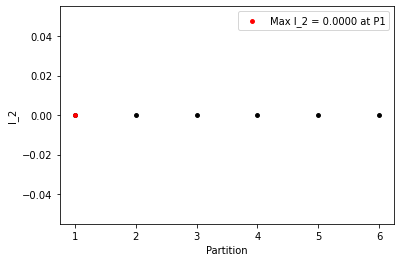


Case 2:

Given (gamma,lambda) = (0.98,-0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]

Matrix B:
[[0.     0.     0.     0.    ]
 [0.0001 0.0002 0.0002 0.    ]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 1. -0.]
 [-0.  1.]]

Minimum value of the cost function:
-6.6981

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.0

Covariance matrix of joint distribution (X,V):
[[ 1.e+00  0.e+00  0.e+00  0.e+00  0.e+00

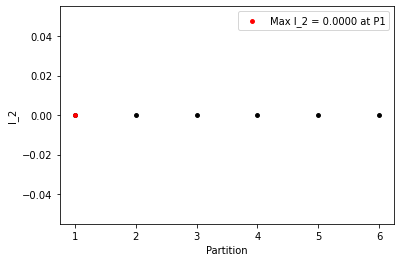


Case 3:

Given (gamma,lambda) = (0.98,0.0), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.  0.]
 [-0.  0.]
 [-0.  0.]
 [-0.  0.]]

Matrix B:
[[ 0.     -0.     -0.0001 -0.    ]
 [ 0.      0.0002  0.0001  0.0001]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[1. 0.]
 [0. 1.]]

Minimum value of the cost function:
-6.698

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.0

Covariance matrix of joint distribution (X,V):
[[ 1.e+00  0.e+00 -0.e+00 -0.e+00  0

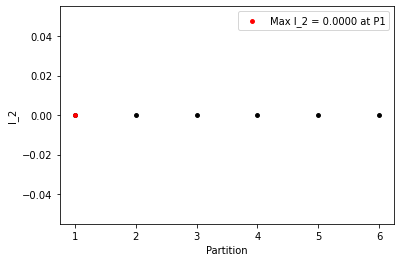


Case 4:

Given (gamma,lambda) = (0.98,0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]

Matrix B:
[[0.0001 0.     0.     0.    ]
 [0.0002 0.     0.     0.    ]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 1. -0.]
 [-0.  1.]]

Minimum value of the cost function:
-6.6979

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.0

Covariance matrix of joint distribution (X,V):
[[ 1.e+00  0.e+00  0.e+00  0.e+00  0.e+00]

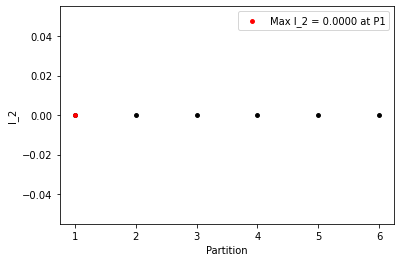


Case 5:

Given (gamma,lambda) = (0.98,0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [-0.  0.]]

Matrix B:
[[ 0.      0.      0.     -0.    ]
 [ 0.      0.0001  0.0001  0.0002]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[1. 0.]
 [0. 1.]]

Minimum value of the cost function:
-6.6979

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.0

Covariance matrix of joint distribution (X,V):
[[ 1.e+00  0.e+00  0.e+00 -0.e+00 

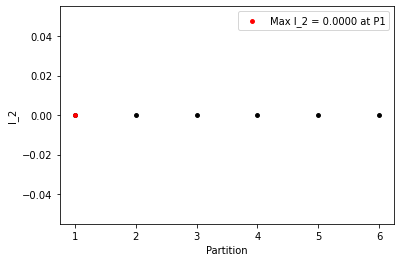


Case 6:

Given (gamma,lambda) = (0.99,-0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.  0.]
 [-0.  0.]
 [-0.  0.]
 [ 0.  0.]]

Matrix B:
[[ 0.     -0.     -0.      0.    ]
 [ 0.0002  0.0002  0.0005  0.0001]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[1. 0.]
 [0. 1.]]

Minimum value of the cost function:
-6.7665

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.0

Covariance matrix of joint distribution (X,V):
[[ 1.e+00  0.e+00 -0.e+00  0.e+00

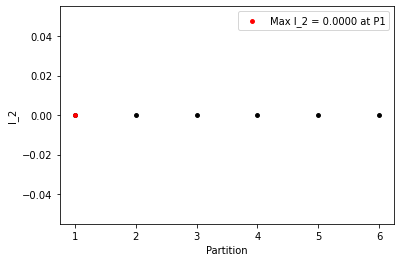


Case 7:

Given (gamma,lambda) = (0.99,-0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.  0.]
 [-0.  0.]
 [-0.  0.]
 [-0.  0.]]

Matrix B:
[[-0.     -0.     -0.     -0.0001]
 [ 0.0003  0.      0.0001  0.0003]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[1. 0.]
 [0. 1.]]

Minimum value of the cost function:
-6.7665

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.0

Covariance matrix of joint distribution (X,V):
[[ 1.e+00  0.e+00 -0.e+00 -0.e+00

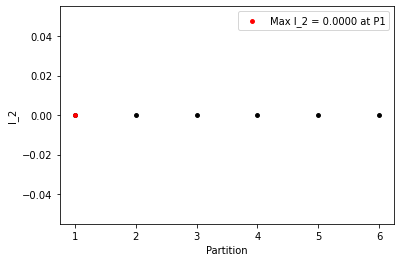


Case 8:

Given (gamma,lambda) = (0.99,0.0), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]

Matrix B:
[[0.     0.     0.     0.    ]
 [0.0001 0.0003 0.0001 0.0004]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 1. -0.]
 [-0.  1.]]

Minimum value of the cost function:
-6.7664

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.0

Covariance matrix of joint distribution (X,V):
[[ 1.e+00  0.e+00  0.e+00  0.e+00  0.e+00]


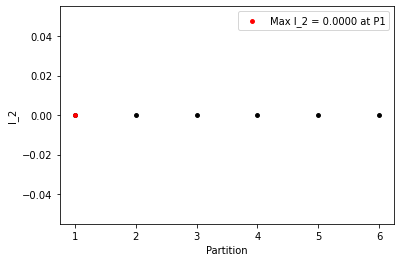


Case 9:

Given (gamma,lambda) = (0.99,0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.  0.]
 [-0.  0.]
 [-0.  0.]
 [-0.  0.]]

Matrix B:
[[ 0.0001 -0.     -0.     -0.0001]
 [ 0.0001  0.0002  0.0001  0.0004]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[1. 0.]
 [0. 1.]]

Minimum value of the cost function:
-6.7663

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.0

Covariance matrix of joint distribution (X,V):
[[ 1.e+00  0.e+00 -0.e+00 -0.e+00 

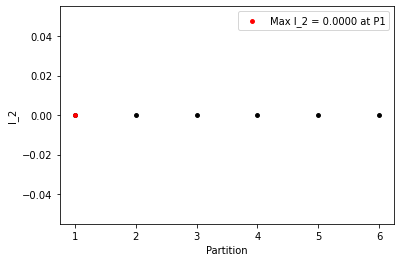


Case 10:

Given (gamma,lambda) = (0.99,0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.  0.]
 [-0.  0.]
 [ 0.  0.]
 [ 0.  0.]]

Matrix B:
[[ 0.     -0.0001  0.0001  0.    ]
 [ 0.0002  0.0002  0.0002  0.0004]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 1. -0.]
 [-0.  1.]]

Minimum value of the cost function:
-6.7662

Mutual information of the encoder:
0.0

Mutual information of the decoder:
0.0

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.0

Covariance matrix of joint distribution (X,V):
[[ 1.e+00  0.e+00 -0.e+00

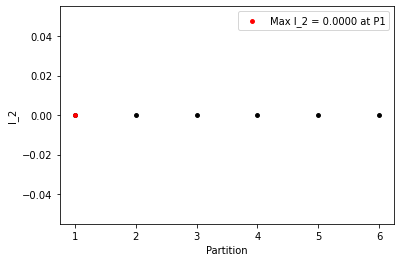


Case 11:

Given (gamma,lambda) = (1.0,-0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0002 -0.    ]
 [ 0.0001 -0.    ]
 [ 0.0003 -0.    ]
 [ 0.0002  0.0012]]

Matrix B:
[[ 0.0772  0.0531  0.1728  0.1002]
 [-0.0121 -0.0084 -0.0275  0.6248]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 9.999e-01 -1.000e-04]
 [-1.000e-04  9.992e-01]]

Minimum value of the cost function:
-6.8349

Mutual information of the encoder:
0.0004

Mutual information of the decoder:
0.0004

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.0001

Cov

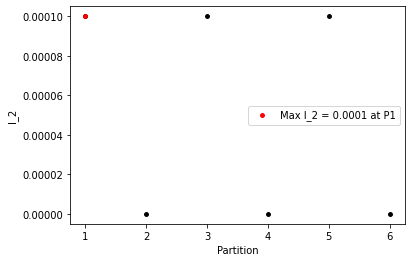


Case 12:

Given (gamma,lambda) = (1.0,-0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0002 -0.0001]
 [ 0.     -0.    ]
 [ 0.0004 -0.0001]
 [ 0.0009  0.0028]]

Matrix B:
[[ 0.0697  0.014   0.247   0.4722]
 [-0.0233 -0.0047 -0.0827  1.4108]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 0.9994 -0.0013]
 [-0.0013  0.996 ]]

Minimum value of the cost function:
-6.8348

Mutual information of the encoder:
0.0023

Mutual information of the decoder:
0.0023

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0025  0.      0.      0.    ]
 [ 0.      0.0017  0.      0.    ]
 [ 0.      0.      0.0016 -0.    ]
 [ 0.      0.     -0.      0.002 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.0004


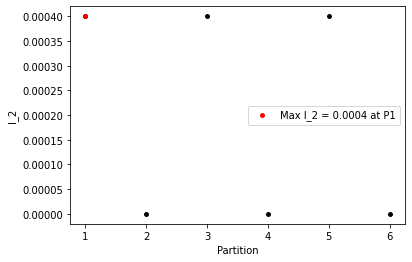


Case 13:

Given (gamma,lambda) = (1.0,0.0), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0005 -0.    ]
 [ 0.0001  0.0016]
 [ 0.0002 -0.    ]
 [ 0.0001 -0.    ]]

Matrix B:
[[ 0.2092  0.0482  0.1048  0.0665]
 [-0.0105  0.9573 -0.0053 -0.0034]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 9.999e-01 -1.000e-04]
 [-1.000e-04  9.984e-01]]

Minimum value of the cost function:
-6.8347

Mutual information of the encoder:
0.0008

Mutual information of the decoder:
0.0008

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0025  0.      0.      0.    ]
 [ 0.      0.0017 -0.     -0.    ]
 [ 0.     -0.      0.0016  0.    ]
 [ 0.     -0.      0.      0.002 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0

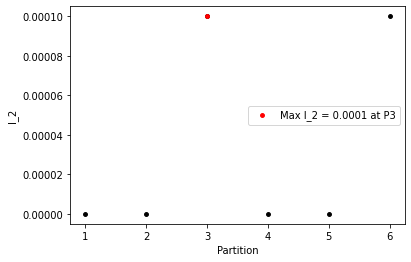


Case 14:

Given (gamma,lambda) = (1.0,0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0001  0.0001]
 [-0.0001  0.    ]
 [ 0.0007  0.0017]
 [ 0.0004 -0.0002]]

Matrix B:
[[-0.0593 -0.0375  0.453   0.2157]
 [ 0.026   0.0164  1.037  -0.0941]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 9.996e-01 -7.000e-04]
 [-7.000e-04  9.983e-01]]

Minimum value of the cost function:
-6.8346

Mutual information of the encoder:
0.0011

Mutual information of the decoder:
0.0011

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0025  0.      0.     -0.    ]
 [ 0.      0.0017  0.     -0.    ]
 [ 0.      0.      0.0016  0.    ]
 [-0.     -0.      0.      0.002 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:


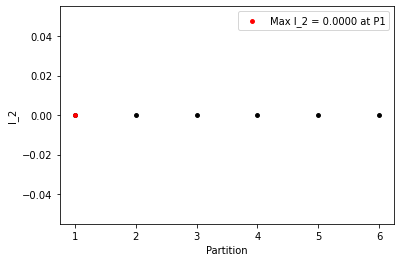


Case 15:

Given (gamma,lambda) = (1.0,0.02), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0021  0.0032]
 [-0.0006  0.0004]
 [-0.0001  0.    ]
 [ 0.     -0.    ]]

Matrix B:
[[ 0.8328 -0.3411 -0.0366  0.0063]
 [ 1.2868  0.2208  0.0237 -0.0041]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 0.9981 -0.0025]
 [-0.0025  0.9958]]

Minimum value of the cost function:
-6.8346

Mutual information of the encoder:
0.0031

Mutual information of the decoder:
0.0031

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0025  0.      0.      0.    ]
 [ 0.      0.0017  0.     -0.    ]
 [ 0.      0.      0.0016 -0.    ]
 [ 0.     -0.     -0.      0.002 ]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.0011

Cova

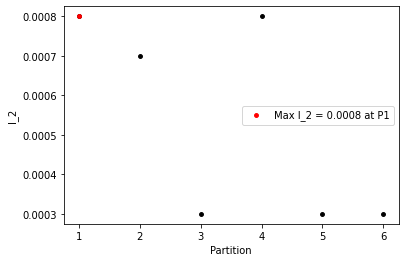


Case 16:

Given (gamma,lambda) = (1.01,-0.02), the reconstruction error = 0.004 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.      0.    ]
 [ 0.0021  0.0411]
 [ 0.     -0.    ]
 [ 0.0446 -0.0022]]

Matrix B:
[[ 0.      1.2231  0.     22.388 ]
 [ 0.     24.2832 -0.     -1.1276]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
-4146.3218

Mutual information of the encoder:
44.872

Mutual information of the decoder:
44.8571

Value of Sigma_X:
[[1.005 0.   ]
 [0.    1.005]]

Value of Sigma_Y_hat:
[[ 0.0025  0.      0.      0.    ]
 [ 0.      0.0017 -0.      0.    ]
 [ 0.     -0.      0.0016  0.    ]
 [ 0.      0.      0.      0.002 ]]

Reconstruction error:
0.004

Mutual information between generative variable and latent variable:
0.1419

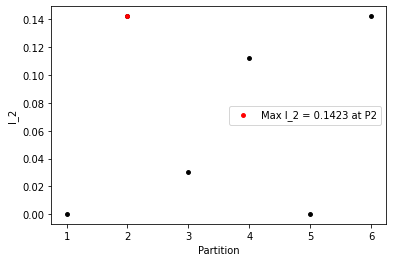


Case 17:

Given (gamma,lambda) = (1.01,-0.01), the reconstruction error = 0.004 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.     -0.    ]
 [-0.0214  0.0351]
 [-0.     -0.    ]
 [ 0.0381  0.0232]]

Matrix B:
[[  0.     -12.6508  -0.      19.1431]
 [ -0.      20.7636  -0.      11.6634]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[0. 0.]
 [0. 0.]]

Minimum value of the cost function:
-16557.2111

Mutual information of the encoder:
45.8062

Mutual information of the decoder:
45.7912

Value of Sigma_X:
[[ 1.005 -0.   ]
 [-0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0025 -0.      0.     -0.    ]
 [-0.      0.0017 -0.     -0.    ]
 [ 0.     -0.      0.0016 -0.    ]
 [-0.     -0.     -0.      0.002 ]]

Reconstruction error:
0.004

Mutual information between generative variable and latent variab

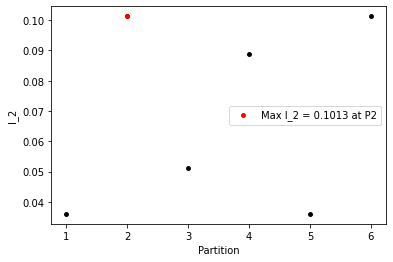


Case 18:

Given (gamma,lambda) = (1.01,0.0), the reconstruction error = 0.004 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.      0.    ]
 [-0.0044  0.0409]
 [-0.      0.    ]
 [ 0.0444  0.0048]]

Matrix B:
[[-0.     -2.6081  0.     22.287 ]
 [ 0.     24.1737  0.      2.4046]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[0. 0.]
 [0. 0.]]

Minimum value of the cost function:
16538.4704

Mutual information of the encoder:
45.6605

Mutual information of the decoder:
45.6455

Value of Sigma_X:
[[1.005 0.   ]
 [0.    1.005]]

Value of Sigma_Y_hat:
[[ 0.0025  0.      0.     -0.    ]
 [ 0.      0.0017  0.     -0.    ]
 [ 0.      0.      0.0016  0.    ]
 [-0.     -0.      0.      0.002 ]]

Reconstruction error:
0.004

Mutual information between generative variable and latent variable:
0.1419

Cov

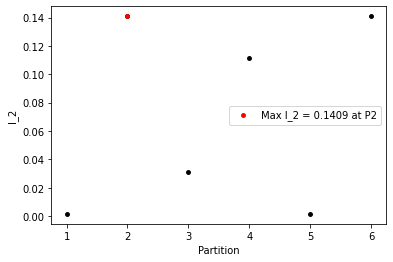


Case 19:

Given (gamma,lambda) = (1.01,0.01), the reconstruction error = 0.004 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.     -0.    ]
 [-0.0041  0.0409]
 [-0.      0.    ]
 [ 0.0444  0.0044]]

Matrix B:
[[ 0.     -2.4029  0.     22.3066]
 [-0.     24.1949  0.      2.2154]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[0. 0.]
 [0. 0.]]

Minimum value of the cost function:
-9.3685

Mutual information of the encoder:
45.5546

Mutual information of the decoder:
45.5397

Value of Sigma_X:
[[1.005 0.   ]
 [0.    1.005]]

Value of Sigma_Y_hat:
[[ 0.0025 -0.      0.      0.    ]
 [-0.      0.0017  0.     -0.    ]
 [ 0.      0.      0.0016  0.    ]
 [ 0.     -0.      0.      0.002 ]]

Reconstruction error:
0.004

Mutual information between generative variable and latent variable:
0.1419

Covar

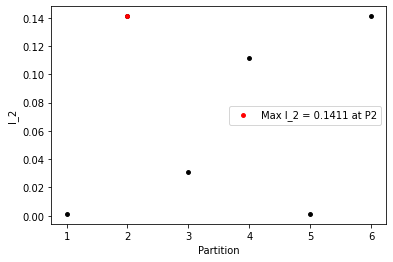


Case 20:

Given (gamma,lambda) = (1.01,0.02), the reconstruction error = 0.0034 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.      0.    ]
 [-0.0008  0.0411]
 [ 0.0399  0.0008]
 [-0.      0.    ]]

Matrix B:
[[ 0.     -0.4752 25.0575 -0.    ]
 [ 0.     24.3093  0.4898  0.    ]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[0. 0.]
 [0. 0.]]

Minimum value of the cost function:
16538.4663

Mutual information of the encoder:
46.0782

Mutual information of the decoder:
46.0633

Value of Sigma_X:
[[ 1.005 -0.   ]
 [-0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0025  0.      0.      0.    ]
 [ 0.      0.0017 -0.      0.    ]
 [ 0.     -0.      0.0016 -0.    ]
 [ 0.      0.     -0.      0.002 ]]

Reconstruction error:
0.0034

Mutual information between generative variable and latent variable:
0.03

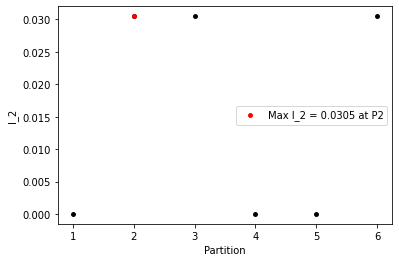


Case 21:

Given (gamma,lambda) = (1.02,-0.02), the reconstruction error = 0.0067 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.     -0.    ]
 [ 0.0323  0.0253]
 [-0.0246  0.0313]
 [ 0.      0.    ]]

Matrix B:
[[ -0.      19.1702 -15.5162   0.    ]
 [ -0.      15.053   19.7602   0.    ]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[0. 0.]
 [0. 0.]]

Minimum value of the cost function:
3.94593387522215e+25

Mutual information of the encoder:
95.0585

Mutual information of the decoder:
95.0288

Value of Sigma_X:
[[ 1.01 -0.  ]
 [-0.    1.01]]

Value of Sigma_Y_hat:
[[ 0.0025 -0.     -0.      0.    ]
 [-0.      0.0017  0.      0.    ]
 [-0.      0.      0.0016  0.    ]
 [ 0.      0.      0.      0.002 ]]

Reconstruction error:
0.0067

Mutual information between generative variable and latent

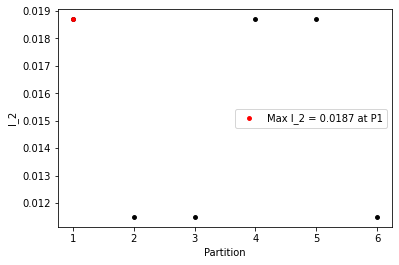


Case 22:

Given (gamma,lambda) = (1.02,-0.01), the reconstruction error = 0.0067 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.      0.    ]
 [ 0.0392 -0.0122]
 [ 0.0118  0.038 ]
 [ 0.      0.    ]]

Matrix B:
[[ 0.     23.2738  7.4628  0.    ]
 [ 0.     -7.24   23.9901  0.    ]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
-10.8913

Mutual information of the encoder:
95.0066

Mutual information of the decoder:
94.9769

Value of Sigma_X:
[[1.01 0.  ]
 [0.   1.01]]

Value of Sigma_Y_hat:
[[ 0.0025  0.      0.      0.    ]
 [ 0.      0.0017 -0.      0.    ]
 [ 0.     -0.      0.0016  0.    ]
 [ 0.      0.      0.      0.002 ]]

Reconstruction error:
0.0067

Mutual information between generative variable and latent variable:
0.0303

C

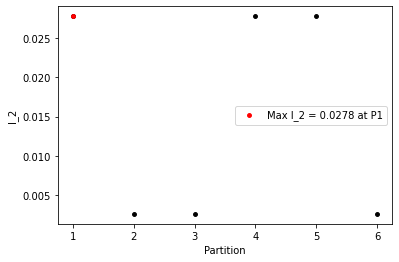


Case 23:

Given (gamma,lambda) = (1.02,0.0), the reconstruction error = 0.0067 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.     -0.    ]
 [-0.0254  0.0322]
 [ 0.0313  0.0246]
 [ 0.     -0.    ]]

Matrix B:
[[ -0.     -15.0937  19.7272   0.    ]
 [ -0.      19.1382  15.5582  -0.    ]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[0. 0.]
 [0. 0.]]

Minimum value of the cost function:
-1.972966937611075e+25

Mutual information of the encoder:
94.7948

Mutual information of the decoder:
94.7651

Value of Sigma_X:
[[1.01 0.  ]
 [0.   1.01]]

Value of Sigma_Y_hat:
[[ 0.0025  0.     -0.      0.    ]
 [ 0.      0.0017 -0.     -0.    ]
 [-0.     -0.      0.0016 -0.    ]
 [ 0.     -0.     -0.      0.002 ]]

Reconstruction error:
0.0067

Mutual information between generative variable and latent var

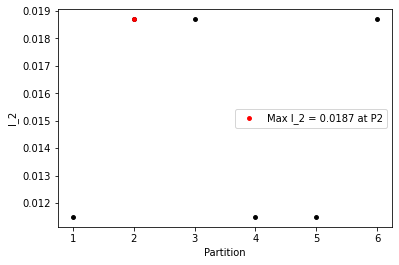


Case 24:

Given (gamma,lambda) = (1.02,0.01), the reconstruction error = 0.0067 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.      0.    ]
 [ 0.035   0.0214]
 [-0.0207  0.034 ]
 [-0.      0.    ]]

Matrix B:
[[ -0.      20.8085 -13.083   -0.    ]
 [  0.      12.6924  21.4489   0.    ]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[0. 0.]
 [0. 0.]]

Minimum value of the cost function:
-1.972966937611075e+25

Mutual information of the encoder:
94.4385

Mutual information of the decoder:
94.4088

Value of Sigma_X:
[[1.01 0.  ]
 [0.   1.01]]

Value of Sigma_Y_hat:
[[ 0.0025  0.      0.      0.    ]
 [ 0.      0.0017  0.     -0.    ]
 [ 0.      0.      0.0016  0.    ]
 [ 0.     -0.      0.      0.002 ]]

Reconstruction error:
0.0067

Mutual information between generative variable and latent va

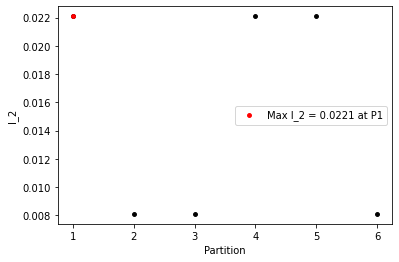


Case 25:

Given (gamma,lambda) = (1.02,0.02), the reconstruction error = 0.0067 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.     -0.    ]
 [ 0.0402  0.008 ]
 [-0.0077  0.039 ]
 [-0.      0.    ]]

Matrix B:
[[-0.     23.9118 -4.8694 -0.    ]
 [-0.      4.724  24.6477  0.    ]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[0. 0.]
 [0. 0.]]

Minimum value of the cost function:
-10.884

Mutual information of the encoder:
94.6457

Mutual information of the decoder:
94.616

Value of Sigma_X:
[[1.01 0.  ]
 [0.   1.01]]

Value of Sigma_Y_hat:
[[ 0.0025 -0.     -0.      0.    ]
 [-0.      0.0017  0.     -0.    ]
 [-0.      0.      0.0016  0.    ]
 [ 0.     -0.      0.      0.002 ]]

Reconstruction error:
0.0067

Mutual information between generative variable and latent variable:
0.0303

Covarian

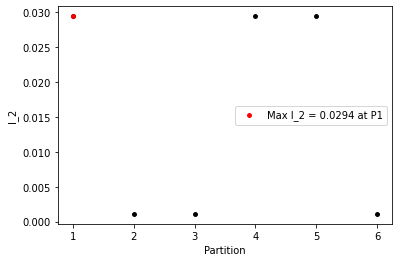

Scenario 2:
Given (sigma_v1, sigma_v3) = (0.01, 0.03), alpha = 2, and sigma_z2 = 0.02:

Covariance matrix of generative variable V:
[[0.0001 0.0002 0.    ]
 [0.0002 0.0008 0.    ]
 [0.     0.     0.0009]]
The matrix is not singular.

Covariance matrix of input data Y:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.0002]
 [0.     0.     0.0016 0.    ]
 [0.     0.0002 0.     0.0024]]
The matrix is positive definite.

Case 1:

Given (gamma,lambda) = (0.98,-0.02), the reconstruction error = 0.0152 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.     -0.    ]
 [ 0.0007  0.0117]
 [ 0.     -0.    ]
 [ 0.0008  0.0138]]

Matrix B:
[[ 0.      0.3686  0.      0.31  ]
 [-0.      6.2399 -0.      5.2479]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0.9995 -0.0086]
 [-0.0086  0.8546]]

Minimum v

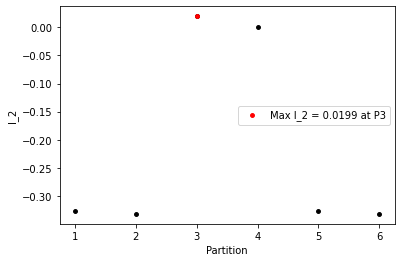


Case 2:

Given (gamma,lambda) = (0.98,-0.01), the reconstruction error = 0.0152 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.     -0.    ]
 [ 0.0016  0.0116]
 [ 0.     -0.    ]
 [ 0.0019  0.0137]]

Matrix B:
[[ 0.      0.8623  0.      0.7255]
 [-0.      6.1913 -0.      5.2089]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0.9972 -0.0199]
 [-0.0199  0.8568]]

Minimum value of the cost function:
-6.6118

Mutual information of the encoder:
0.0789

Mutual information of the decoder:
0.0804

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0025  0.      0.      0.    ]
 [ 0.      0.0017 -0.      0.0002]
 [ 0.     -0.      0.0016  0.    ]
 [ 0.      0.0002  0.      0.0024]]

Reconstruction error:
0.0152

Mutual information between generative variable and latent variable:
0.02


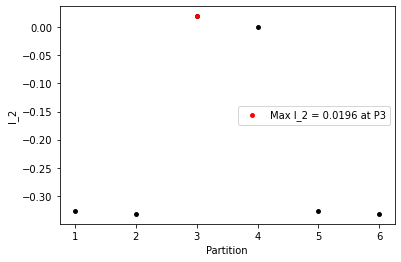


Case 3:

Given (gamma,lambda) = (0.98,0.0), the reconstruction error = 0.0152 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.      0.    ]
 [ 0.0024  0.0114]
 [-0.      0.    ]
 [ 0.0028  0.0136]]

Matrix B:
[[-0.      1.2684 -0.      1.0676]
 [ 0.      6.1214  0.      5.1519]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0.994 -0.029]
 [-0.029  0.86 ]]

Minimum value of the cost function:
-6.6117

Mutual information of the encoder:
0.0789

Mutual information of the decoder:
0.0804

Value of Sigma_X:
[[ 1.  0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0025  0.      0.     -0.    ]
 [ 0.      0.0017  0.      0.0002]
 [ 0.      0.      0.0016 -0.    ]
 [-0.      0.0002 -0.      0.0024]]

Reconstruction error:
0.0152

Mutual information between generative variable and latent variable:
0.02

C

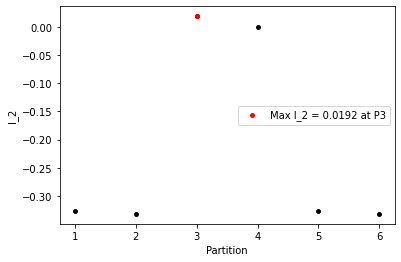


Case 4:

Given (gamma,lambda) = (0.98,0.01), the reconstruction error = 0.0151 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.     -0.    ]
 [ 0.0027  0.0114]
 [-0.      0.    ]
 [ 0.0032  0.0135]]

Matrix B:
[[ 0.      1.4232 -0.      1.1983]
 [-0.      6.0876  0.      5.1253]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0.9924 -0.0324]
 [-0.0324  0.8615]]

Minimum value of the cost function:
-6.6117

Mutual information of the encoder:
0.079

Mutual information of the decoder:
0.0805

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0025 -0.     -0.      0.    ]
 [-0.      0.0017  0.      0.0002]
 [-0.      0.      0.0016 -0.    ]
 [ 0.      0.0002 -0.      0.0024]]

Reconstruction error:
0.0151

Mutual information between generative variable and latent variable:
0.02

C

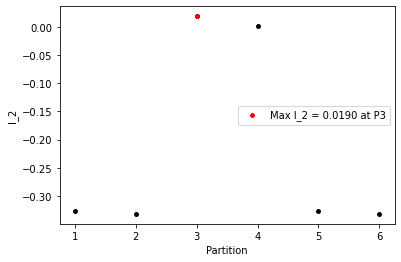


Case 5:

Given (gamma,lambda) = (0.98,0.02), the reconstruction error = 0.0151 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.      0.    ]
 [ 0.0073  0.0091]
 [-0.      0.    ]
 [ 0.0087  0.0109]]

Matrix B:
[[-0.      3.8956 -0.      3.2809]
 [ 0.      4.8901  0.      4.1185]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0.9433 -0.0712]
 [-0.0712  0.9106]]

Minimum value of the cost function:
-6.6116

Mutual information of the encoder:
0.079

Mutual information of the decoder:
0.0805

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0025 -0.      0.     -0.    ]
 [-0.      0.0017 -0.      0.0002]
 [ 0.     -0.      0.0016  0.    ]
 [-0.      0.0002  0.      0.0024]]

Reconstruction error:
0.0151

Mutual information between generative variable and latent variable:
0.02

C

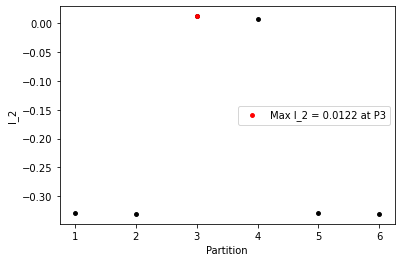


Case 6:

Given (gamma,lambda) = (0.99,-0.02), the reconstruction error = 0.0075 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.      0.    ]
 [ 0.0048  0.0114]
 [-0.      0.    ]
 [ 0.0057  0.0135]]

Matrix B:
[[-0.      2.5675 -0.      2.1579]
 [ 0.      6.0974  0.      5.1246]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0015 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0.9754 -0.0584]
 [-0.0584  0.8613]]

Minimum value of the cost function:
-6.6802

Mutual information of the encoder:
0.0892

Mutual information of the decoder:
0.09

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.0002]
 [0.     0.     0.0016 0.    ]
 [0.     0.0002 0.     0.0024]]

Reconstruction error:
0.0075

Mutual information between generative variable and latent variable:
0.0224

Covariance 

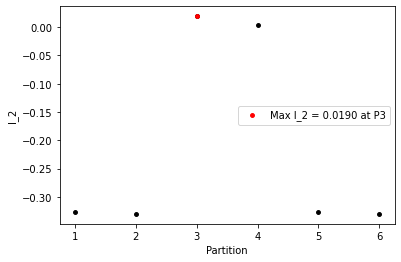


Case 7:

Given (gamma,lambda) = (0.99,-0.01), the reconstruction error = 0.0075 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.      0.    ]
 [ 0.0081  0.0094]
 [-0.      0.    ]
 [ 0.0096  0.0111]]

Matrix B:
[[-0.      4.3124 -0.      3.6269]
 [ 0.      5.0161  0.      4.2187]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0015 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0.9306 -0.0808]
 [-0.0808  0.906 ]]

Minimum value of the cost function:
-6.6801

Mutual information of the encoder:
0.0892

Mutual information of the decoder:
0.09

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0025  0.      0.     -0.    ]
 [ 0.      0.0017  0.      0.0002]
 [ 0.      0.      0.0016 -0.    ]
 [-0.      0.0002 -0.      0.0024]]

Reconstruction error:
0.0075

Mutual information between generative variable and latent variable:
0.0224


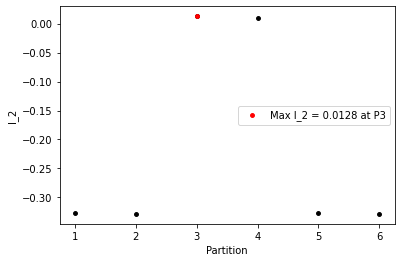


Case 8:

Given (gamma,lambda) = (0.99,0.0), the reconstruction error = 0.0074 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.     -0.    ]
 [ 0.0044  0.0115]
 [ 0.     -0.    ]
 [ 0.0052  0.0137]]

Matrix B:
[[ 0.      2.3566  0.      1.9834]
 [-0.      6.1799 -0.      5.2011]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0015 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0.9792 -0.0544]
 [-0.0544  0.8573]]

Minimum value of the cost function:
-6.6801

Mutual information of the encoder:
0.0892

Mutual information of the decoder:
0.0901

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0025 -0.      0.      0.    ]
 [-0.      0.0017 -0.      0.0002]
 [ 0.     -0.      0.0016  0.    ]
 [ 0.      0.0002  0.      0.0024]]

Reconstruction error:
0.0074

Mutual information between generative variable and latent variable:
0.0224


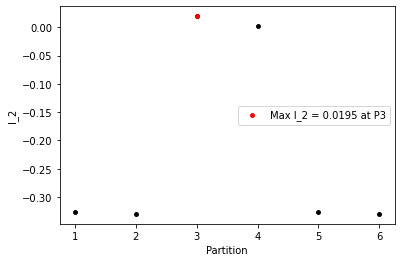


Case 9:

Given (gamma,lambda) = (0.99,0.01), the reconstruction error = 0.0074 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.     -0.    ]
 [ 0.0032  0.0119]
 [ 0.     -0.    ]
 [ 0.0038  0.0142]]

Matrix B:
[[ 0.      1.7204  0.      1.449 ]
 [-0.      6.3852 -0.      5.3777]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0015 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0.9889 -0.0411]
 [-0.0411  0.8475]]

Minimum value of the cost function:
-6.68

Mutual information of the encoder:
0.0893

Mutual information of the decoder:
0.0901

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0025  0.      0.     -0.    ]
 [ 0.      0.0017  0.      0.0002]
 [ 0.      0.      0.0016 -0.    ]
 [-0.      0.0002 -0.      0.0024]]

Reconstruction error:
0.0074

Mutual information between generative variable and latent variable:
0.0225



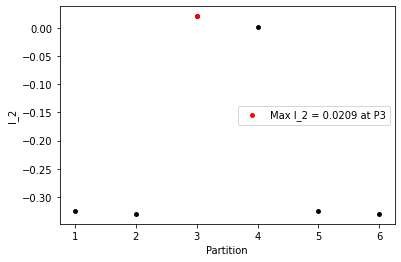


Case 10:

Given (gamma,lambda) = (0.99,0.02), the reconstruction error = 0.0074 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.      0.    ]
 [ 0.0046  0.0114]
 [ 0.     -0.    ]
 [ 0.0055  0.0136]]

Matrix B:
[[-0.      2.4846  0.      2.0941]
 [ 0.      6.1273 -0.      5.1641]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0015 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0.9769 -0.057 ]
 [-0.057   0.8595]]

Minimum value of the cost function:
-6.6799

Mutual information of the encoder:
0.0893

Mutual information of the decoder:
0.0901

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0025  0.     -0.      0.    ]
 [ 0.      0.0017 -0.      0.0002]
 [-0.     -0.      0.0016 -0.    ]
 [ 0.      0.0002 -0.      0.0024]]

Reconstruction error:
0.0074

Mutual information between generative variable and latent variable:
0

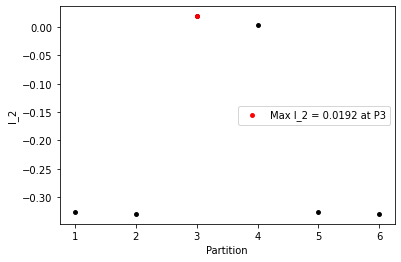


Case 11:

Given (gamma,lambda) = (1.0,-0.02), the reconstruction error = 0.0001 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0003  0.0006]
 [ 0.0118  0.0064]
 [-0.      0.0001]
 [ 0.013   0.0071]]

Matrix B:
[[-0.1293  6.3903 -0.0285  4.8968]
 [ 0.238   3.4724  0.0525  2.6598]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0015 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0.8605 -0.0757]
 [-0.0757  0.9587]]

Minimum value of the cost function:
-6.7486

Mutual information of the encoder:
0.0997

Mutual information of the decoder:
0.0997

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0025  0.      0.     -0.    ]
 [ 0.      0.0017  0.      0.0002]
 [ 0.      0.      0.0016 -0.    ]
 [-0.      0.0002 -0.      0.0024]]

Reconstruction error:
0.0001

Mutual information between generative variable and latent variable:
0.023

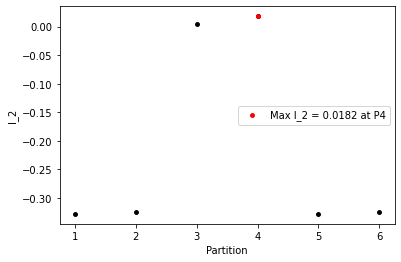


Case 12:

Given (gamma,lambda) = (1.0,-0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0001  0.0005]
 [ 0.013   0.0026]
 [-0.      0.0002]
 [ 0.0148  0.0029]]

Matrix B:
[[-0.0388  6.9951 -0.0192  5.5778]
 [ 0.195   1.3909  0.0967  1.1101]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0015 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0.8265 -0.0345]
 [-0.0345  0.993 ]]

Minimum value of the cost function:
-6.7486

Mutual information of the encoder:
0.0995

Mutual information of the decoder:
0.0995

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0025 -0.      0.      0.    ]
 [-0.      0.0017 -0.      0.0002]
 [ 0.     -0.      0.0016  0.    ]
 [ 0.      0.0002  0.      0.0024]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.0242

Cov

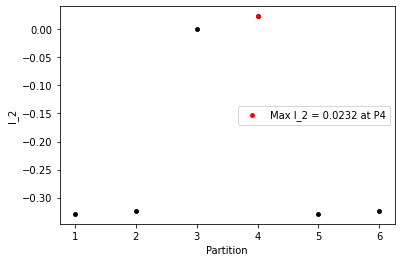


Case 13:

Given (gamma,lambda) = (1.0,0.0), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0001 -0.    ]
 [ 0.0014  0.0128]
 [ 0.     -0.    ]
 [ 0.0017  0.0154]]

Matrix B:
[[ 5.9700e-02  7.7690e-01  1.6300e-02  6.2700e-01]
 [-6.6000e-03  6.8692e+00 -1.8000e-03  5.8373e+00]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0015 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0.9978 -0.0196]
 [-0.0196  0.822 ]]

Minimum value of the cost function:
-6.7485

Mutual information of the encoder:
0.0993

Mutual information of the decoder:
0.0993

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0025  0.      0.     -0.    ]
 [ 0.      0.0017  0.      0.0002]
 [ 0.      0.      0.0016 -0.    ]
 [-0.      0.0002 -0.      0.0024]]

Reconstruction error:
0.0

Mutual information between generative variable an

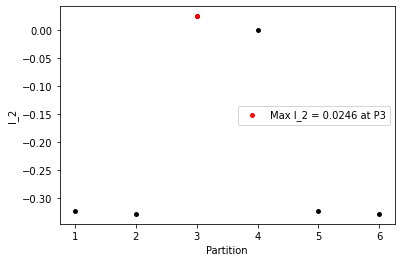


Case 14:

Given (gamma,lambda) = (1.0,0.01), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0009  0.0004]
 [ 0.0043  0.0117]
 [-0.      0.    ]
 [ 0.0056  0.015 ]]

Matrix B:
[[-3.7770e-01  2.3030e+00 -1.1200e-02  2.1445e+00]
 [ 1.4070e-01  6.1927e+00  4.2000e-03  5.7531e+00]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0015 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0021]]

Covariance matrix of W:
[[ 0.9776 -0.059 ]
 [-0.059   0.8411]]

Minimum value of the cost function:
-6.7484

Mutual information of the encoder:
0.1

Mutual information of the decoder:
0.1

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0025  0.      0.     -0.    ]
 [ 0.      0.0017  0.      0.0002]
 [ 0.      0.      0.0016 -0.    ]
 [-0.      0.0002 -0.      0.0024]]

Reconstruction error:
0.0

Mutual information between generative variable and lat

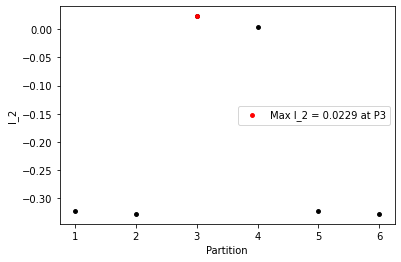


Case 15:

Given (gamma,lambda) = (1.0,0.02), the reconstruction error = 0.0001 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0007 -0.0002]
 [ 0.0039  0.0115]
 [-0.0001  0.    ]
 [ 0.0052  0.0156]]

Matrix B:
[[ 0.2804  2.0388 -0.0476  2.0089]
 [-0.094   6.0756  0.016   5.9964]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0021]]

Covariance matrix of W:
[[ 0.9814 -0.0548]
 [-0.0548  0.8364]]

Minimum value of the cost function:
-6.7483

Mutual information of the encoder:
0.1006

Mutual information of the decoder:
0.1006

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0025  0.     -0.     -0.    ]
 [ 0.      0.0017 -0.      0.0002]
 [-0.     -0.      0.0016  0.    ]
 [-0.      0.0002  0.      0.0024]]

Reconstruction error:
0.0001

Mutual information between generative variable and latent variable:
0.0269

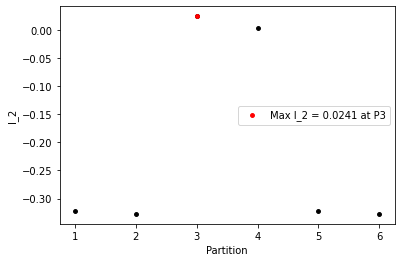


Case 16:

Given (gamma,lambda) = (1.01,-0.02), the reconstruction error = 0.0034 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.     -0.    ]
 [ 0.002   0.0411]
 [ 0.0399 -0.002 ]
 [ 0.0002  0.0048]]

Matrix B:
[[ 0.      1.1979 25.0318  0.    ]
 [-0.     24.2844 -1.2347  0.    ]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0024]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
198564.7881

Mutual information of the encoder:
46.5913

Mutual information of the decoder:
46.5764

Value of Sigma_X:
[[ 1.005 -0.   ]
 [-0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0025 -0.      0.     -0.    ]
 [-0.      0.0017 -0.      0.0002]
 [ 0.     -0.      0.0016 -0.    ]
 [-0.      0.0002 -0.      0.0024]]

Reconstruction error:
0.0034

Mutual information between generative variable and latent variable

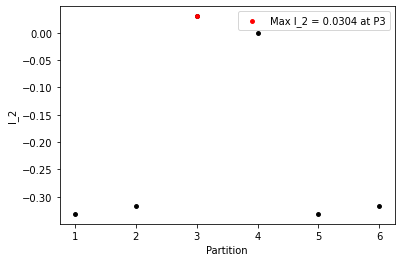


Case 17:

Given (gamma,lambda) = (1.01,-0.01), the reconstruction error = 0.0048 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.      0.    ]
 [ 0.002   0.0036]
 [ 0.0349 -0.0193]
 [ 0.0236  0.0428]]

Matrix B:
[[ -0.       0.      21.9323   9.9026]
 [  0.       0.     -12.1282  17.9076]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
-16557.1212

Mutual information of the encoder:
45.5206

Mutual information of the decoder:
45.5057

Value of Sigma_X:
[[ 1.005 -0.   ]
 [-0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0025  0.     -0.      0.    ]
 [ 0.      0.0017 -0.      0.0002]
 [-0.     -0.      0.0016 -0.    ]
 [ 0.      0.0002 -0.      0.0024]]

Reconstruction error:
0.0048

Mutual information between generative variable and latent 

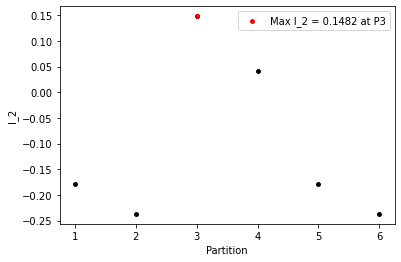


Case 18:

Given (gamma,lambda) = (1.01,0.0), the reconstruction error = 0.0034 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.      0.    ]
 [ 0.0231  0.034 ]
 [-0.033   0.0224]
 [ 0.0027  0.004 ]]

Matrix B:
[[ -0.      13.6617 -20.7319   0.    ]
 [  0.      20.1128  14.0822   0.    ]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0024]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
-8283.1984

Mutual information of the encoder:
45.2469

Mutual information of the decoder:
45.232

Value of Sigma_X:
[[ 1.005 -0.   ]
 [-0.     1.005]]

Value of Sigma_Y_hat:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.0002]
 [0.     0.     0.0016 0.    ]
 [0.     0.0002 0.     0.0024]]

Reconstruction error:
0.0034

Mutual information between generative variable and latent variable:
0.0303

Co

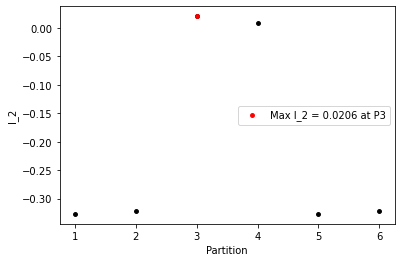


Case 19:

Given (gamma,lambda) = (1.01,0.01), the reconstruction error = 0.0048 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.     -0.    ]
 [ 0.0006  0.004 ]
 [-0.0394  0.0061]
 [ 0.0074  0.0483]]

Matrix B:
[[ -0.       0.     -24.7711   3.1104]
 [ -0.       0.       3.8094  20.2255]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
-33104.967

Mutual information of the encoder:
46.1141

Mutual information of the decoder:
46.0992

Value of Sigma_X:
[[ 1.005 -0.   ]
 [-0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0025 -0.      0.     -0.    ]
 [-0.      0.0017  0.      0.0002]
 [ 0.      0.      0.0016  0.    ]
 [-0.      0.0002  0.      0.0024]]

Reconstruction error:
0.0048

Mutual information between generative variable and latent va

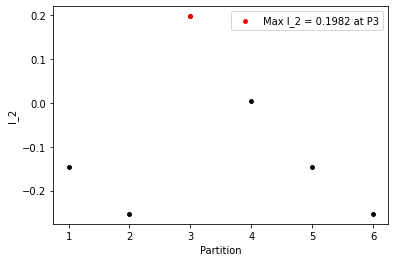


Case 20:

Given (gamma,lambda) = (1.01,0.02), the reconstruction error = 0.0048 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.      0.    ]
 [ 0.0022  0.0035]
 [-0.0338  0.0212]
 [ 0.0259  0.0414]]

Matrix B:
[[  0.       0.     -21.2379  10.8648]
 [  0.       0.      13.3067  17.3407]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
-33104.9588

Mutual information of the encoder:
45.2942

Mutual information of the decoder:
45.2792

Value of Sigma_X:
[[ 1.005 -0.   ]
 [-0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0025  0.     -0.      0.    ]
 [ 0.      0.0017 -0.      0.0002]
 [-0.     -0.      0.0016 -0.    ]
 [ 0.      0.0002 -0.      0.0024]]

Reconstruction error:
0.0048

Mutual information between generative variable and latent v

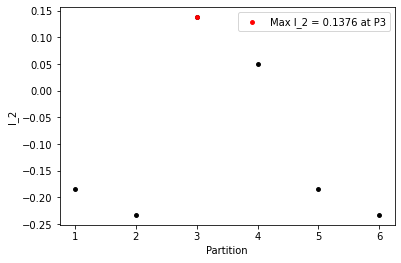


Case 21:

Given (gamma,lambda) = (1.02,-0.02), the reconstruction error = 0.0095 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.      0.    ]
 [-0.0002  0.0041]
 [-0.0398 -0.0015]
 [-0.0018  0.0487]]

Matrix B:
[[  0.      -0.     -25.1064  -0.7702]
 [  0.       0.      -0.9434  20.4992]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[0. 0.]
 [0. 0.]]

Minimum value of the cost function:
-10.8097

Mutual information of the encoder:
95.3216

Mutual information of the decoder:
95.2919

Value of Sigma_X:
[[1.01   0.    ]
 [0.     1.0099]]

Value of Sigma_Y_hat:
[[ 0.0025  0.     -0.      0.    ]
 [ 0.      0.0017 -0.      0.0002]
 [-0.     -0.      0.0016 -0.    ]
 [ 0.      0.0002 -0.      0.0024]]

Reconstruction error:
0.0095

Mutual information between generative variable and latent variabl

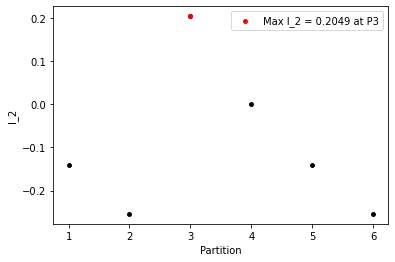


Case 22:

Given (gamma,lambda) = (1.02,-0.01), the reconstruction error = 0.0068 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.      0.    ]
 [ 0.0004  0.041 ]
 [ 0.0398 -0.0004]
 [ 0.0001  0.0048]]

Matrix B:
[[-0.      0.266  25.1226  0.    ]
 [ 0.     24.3725 -0.2742  0.    ]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0024]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
1.972966937611075e+25

Mutual information of the encoder:
94.3106

Mutual information of the decoder:
94.2809

Value of Sigma_X:
[[ 1.01   -0.    ]
 [-0.      1.0099]]

Value of Sigma_Y_hat:
[[ 0.0025  0.     -0.      0.    ]
 [ 0.      0.0017 -0.      0.0002]
 [-0.     -0.      0.0016 -0.    ]
 [ 0.      0.0002 -0.      0.0024]]

Reconstruction error:
0.0068

Mutual information between generative variable and l

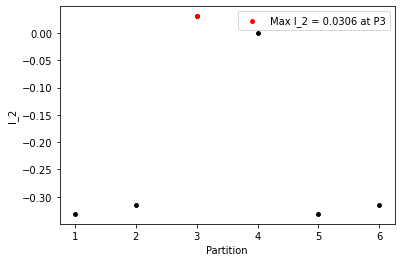


Case 23:

Given (gamma,lambda) = (1.02,0.0), the reconstruction error = 0.0099 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0402  0.0293]
 [ 0.0242  0.0332]
 [ 0.      0.    ]
 [ 0.0028  0.0039]]

Matrix B:
[[-16.2407  14.3598   0.       0.    ]
 [ 11.8414  19.6948   0.       0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0024]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
-10.8067

Mutual information of the encoder:
95.1758

Mutual information of the decoder:
95.1461

Value of Sigma_X:
[[ 1.0099 -0.    ]
 [-0.      1.0099]]

Value of Sigma_Y_hat:
[[ 0.0025 -0.      0.     -0.    ]
 [-0.      0.0017  0.      0.0002]
 [ 0.      0.      0.0016  0.    ]
 [-0.      0.0002  0.      0.0024]]

Reconstruction error:
0.0099

Mutual information between generative variable and latent v

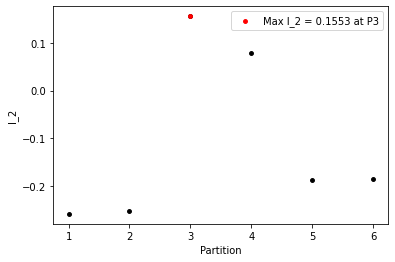


Case 24:

Given (gamma,lambda) = (1.02,0.01), the reconstruction error = 0.0068 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.     -0.    ]
 [ 0.0403  0.0079]
 [-0.0077  0.0391]
 [ 0.0047  0.0009]]

Matrix B:
[[ 0.     23.9147 -4.8538  0.    ]
 [-0.      4.7088 24.6508  0.    ]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.0024]]

Covariance matrix of W:
[[0. 0.]
 [0. 0.]]

Minimum value of the cost function:
-1.57837355008886e+26

Mutual information of the encoder:
95.2

Mutual information of the decoder:
95.1703

Value of Sigma_X:
[[ 1.0099 -0.    ]
 [-0.      1.01  ]]

Value of Sigma_Y_hat:
[[ 0.0025  0.     -0.      0.    ]
 [ 0.      0.0017 -0.      0.0002]
 [-0.     -0.      0.0016 -0.    ]
 [ 0.      0.0002 -0.      0.0024]]

Reconstruction error:
0.0068

Mutual information between generative variable and latent va

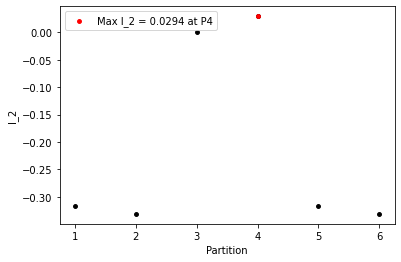


Case 25:

Given (gamma,lambda) = (1.02,0.02), the reconstruction error = 0.0095 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.     -0.    ]
 [ 0.0009  0.004 ]
 [-0.0387  0.0092]
 [ 0.0112  0.0474]]

Matrix B:
[[ -0.       0.     -24.4471   4.7299]
 [ -0.       0.       5.793   19.961 ]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[0. 0.]
 [0. 0.]]

Minimum value of the cost function:
-10.8042

Mutual information of the encoder:
95.0535

Mutual information of the decoder:
95.0238

Value of Sigma_X:
[[ 1.01   -0.    ]
 [-0.      1.0099]]

Value of Sigma_Y_hat:
[[ 0.0025 -0.      0.     -0.    ]
 [-0.      0.0017  0.      0.0002]
 [ 0.      0.      0.0016  0.    ]
 [-0.      0.0002  0.      0.0024]]

Reconstruction error:
0.0095

Mutual information between generative variable and latent vari

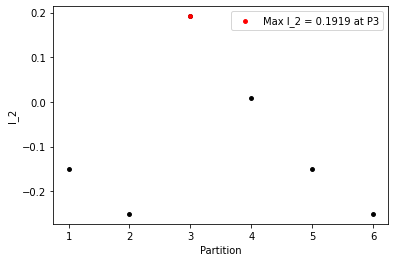

Scenario 3:
Given sigma_v1 = 0.01, (alpha, beta) = (2, 4), and (sigma_z2, sigma_z3) = (0.02, 0.03):

Covariance matrix of generative variable V:
[[0.0001 0.0002 0.0004]
 [0.0002 0.0008 0.0008]
 [0.0004 0.0008 0.0025]]
The matrix is not singular.

Covariance matrix of input data Y:
[[0.0041 0.0004 0.     0.0008]
 [0.0004 0.0017 0.     0.0002]
 [0.     0.     0.0016 0.    ]
 [0.0008 0.0002 0.     0.0024]]
The matrix is positive definite.

Case 1:

Given (gamma,lambda) = (0.98,-0.02), the reconstruction error = 0.0152 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0135  0.0327]
 [ 0.0039  0.0095]
 [-0.      0.    ]
 [ 0.0081  0.0197]]

Matrix B:
[[ 2.6879  1.4023 -0.      2.3724]
 [ 6.5222  3.4028  0.      5.7567]]

Covariance matrix of Z:
[[0.0028 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0019]]

Covariance matrix of W:
[[ 0.939  -0.1481]
 [-0.1481  0.6407

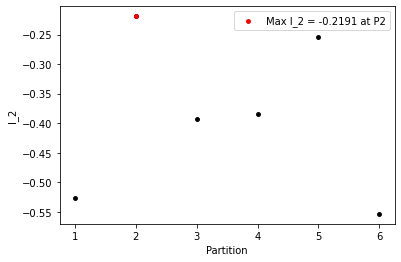


Case 2:

Given (gamma,lambda) = (0.98,-0.01), the reconstruction error = 0.0151 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.011   0.0336]
 [ 0.0032  0.0098]
 [ 0.     -0.    ]
 [ 0.0066  0.0203]]

Matrix B:
[[ 2.1915  1.1427  0.      1.9329]
 [ 6.7082  3.4978 -0.      5.9168]]

Covariance matrix of Z:
[[0.0028 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0019]]

Covariance matrix of W:
[[ 0.9595 -0.1241]
 [-0.1241  0.6201]]

Minimum value of the cost function:
-6.4068

Mutual information of the encoder:
0.2727

Mutual information of the decoder:
0.277

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004  0.      0.0008]
 [ 0.0004  0.0017  0.      0.0002]
 [ 0.      0.      0.0016 -0.    ]
 [ 0.0008  0.0002 -0.      0.0024]]

Reconstruction error:
0.0151

Mutual information between generative variable and latent variable:
0.1486

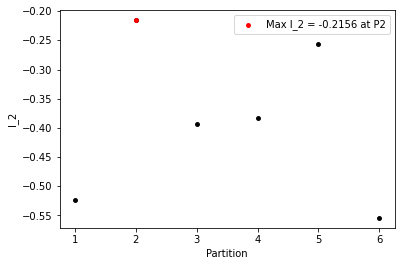


Case 3:

Given (gamma,lambda) = (0.98,0.0), the reconstruction error = 0.0151 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0071  0.0347]
 [-0.0021  0.0101]
 [ 0.      0.    ]
 [-0.0043  0.0209]]

Matrix B:
[[-1.4121 -0.7359  0.     -1.2446]
 [ 6.9171  3.6046  0.      6.0969]]

Covariance matrix of Z:
[[0.0028 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0019]]

Covariance matrix of W:
[[0.9832 0.0824]
 [0.0824 0.5963]]

Minimum value of the cost function:
-6.4067

Mutual information of the encoder:
0.2728

Mutual information of the decoder:
0.2771

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004  0.      0.0008]
 [ 0.0004  0.0017  0.      0.0002]
 [ 0.      0.      0.0016 -0.    ]
 [ 0.0008  0.0002 -0.      0.0024]]

Reconstruction error:
0.0151

Mutual information between generative variable and latent variable:
0.1486


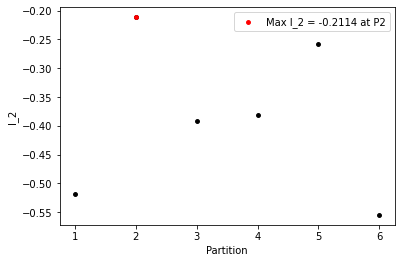


Case 4:

Given (gamma,lambda) = (0.98,0.01), the reconstruction error = 0.0151 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0261  0.0239]
 [ 0.0076  0.007 ]
 [-0.      0.    ]
 [ 0.0157  0.0144]]

Matrix B:
[[ 5.2103  2.7136 -0.      4.5893]
 [ 4.7679  2.4832  0.      4.1996]]

Covariance matrix of Z:
[[0.0028 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0019]]

Covariance matrix of W:
[[ 0.7711 -0.2095]
 [-0.2095  0.8083]]

Minimum value of the cost function:
-6.4067

Mutual information of the encoder:
0.2729

Mutual information of the decoder:
0.2772

Value of Sigma_X:
[[ 1. -0.]
 [ 0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004  0.      0.0008]
 [ 0.0004  0.0017  0.      0.0002]
 [ 0.      0.      0.0016 -0.    ]
 [ 0.0008  0.0002 -0.      0.0024]]

Reconstruction error:
0.0151

Mutual information between generative variable and latent variable:
0.

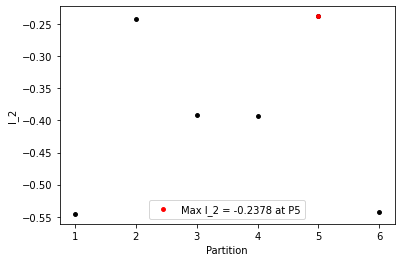


Case 5:

Given (gamma,lambda) = (0.98,0.02), the reconstruction error = 0.015 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0049  0.0351]
 [ 0.0014  0.0102]
 [-0.      0.    ]
 [ 0.003   0.0211]]

Matrix B:
[[ 0.9796  0.5099 -0.      0.8623]
 [ 6.9971  3.642   0.      6.1589]]

Covariance matrix of Z:
[[0.0028 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0019]]

Covariance matrix of W:
[[ 0.9919 -0.0578]
 [-0.0578  0.5874]]

Minimum value of the cost function:
-6.4066

Mutual information of the encoder:
0.273

Mutual information of the decoder:
0.2772

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004  0.      0.0008]
 [ 0.0004  0.0017  0.      0.0002]
 [ 0.      0.      0.0016 -0.    ]
 [ 0.0008  0.0002 -0.      0.0024]]

Reconstruction error:
0.015

Mutual information between generative variable and latent variable:
0.1487

C

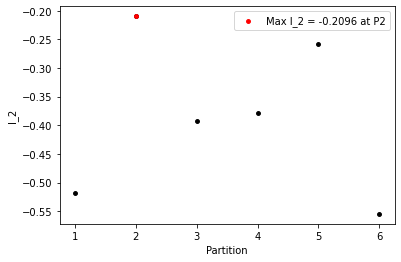


Case 6:

Given (gamma,lambda) = (0.99,-0.02), the reconstruction error = 0.0088 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0126  0.0348]
 [ 0.0035  0.0097]
 [ 0.     -0.    ]
 [ 0.0071  0.0197]]

Matrix B:
[[ 2.5504  1.2125  0.      2.0177]
 [ 7.0692  3.361  -0.      5.5926]]

Covariance matrix of Z:
[[0.0027 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 0.9494 -0.1403]
 [-0.1403  0.6111]]

Minimum value of the cost function:
-6.4751

Mutual information of the encoder:
0.2895

Mutual information of the decoder:
0.2918

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004 -0.      0.0008]
 [ 0.0004  0.0017 -0.      0.0002]
 [-0.     -0.      0.0016  0.    ]
 [ 0.0008  0.0002  0.      0.0024]]

Reconstruction error:
0.0088

Mutual information between generative variable and latent variable:
0.158

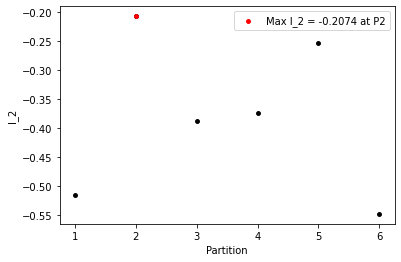


Case 7:

Given (gamma,lambda) = (0.99,-0.01), the reconstruction error = 0.0087 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0144  0.0341]
 [ 0.004   0.0095]
 [-0.      0.    ]
 [ 0.0082  0.0193]]

Matrix B:
[[ 2.9205  1.3875 -0.      2.308 ]
 [ 6.9287  3.2914  0.      5.4759]]

Covariance matrix of Z:
[[0.0027 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 0.9337 -0.1574]
 [-0.1574  0.6266]]

Minimum value of the cost function:
-6.4751

Mutual information of the encoder:
0.2896

Mutual information of the decoder:
0.2919

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004 -0.      0.0008]
 [ 0.0004  0.0017 -0.      0.0002]
 [-0.     -0.      0.0016  0.    ]
 [ 0.0008  0.0002  0.      0.0024]]

Reconstruction error:
0.0087

Mutual information between generative variable and latent variable:
0.159

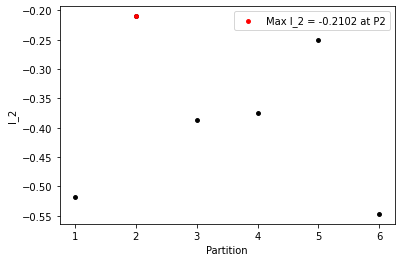


Case 8:

Given (gamma,lambda) = (0.99,0.0), the reconstruction error = 0.0087 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.008   0.0361]
 [ 0.0022  0.01  ]
 [ 0.     -0.    ]
 [ 0.0045  0.0205]]

Matrix B:
[[ 1.6261  0.7717  0.      1.2839]
 [ 7.3451  3.4863 -0.      5.799 ]]

Covariance matrix of Z:
[[0.0027 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 0.9794 -0.0928]
 [-0.0928  0.5807]]

Minimum value of the cost function:
-6.475

Mutual information of the encoder:
0.2898

Mutual information of the decoder:
0.292

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004 -0.      0.0008]
 [ 0.0004  0.0017 -0.      0.0002]
 [-0.     -0.      0.0016  0.    ]
 [ 0.0008  0.0002  0.      0.0024]]

Reconstruction error:
0.0087

Mutual information between generative variable and latent variable:
0.159

Co

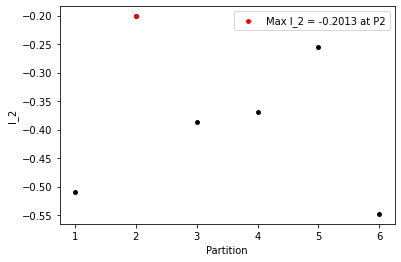


Case 9:

Given (gamma,lambda) = (0.99,0.01), the reconstruction error = 0.0087 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.013   0.0347]
 [ 0.0036  0.0096]
 [ 0.     -0.    ]
 [ 0.0074  0.0196]]

Matrix B:
[[ 2.6489  1.2563  0.      2.0891]
 [ 7.0453  3.3411 -0.      5.5567]]

Covariance matrix of Z:
[[0.0027 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 0.9455 -0.1449]
 [-0.1449  0.6145]]

Minimum value of the cost function:
-6.4749

Mutual information of the encoder:
0.2899

Mutual information of the decoder:
0.2921

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004  0.      0.0008]
 [ 0.0004  0.0017  0.      0.0002]
 [ 0.      0.      0.0016 -0.    ]
 [ 0.0008  0.0002 -0.      0.0024]]

Reconstruction error:
0.0087

Mutual information between generative variable and latent variable:
0.1591

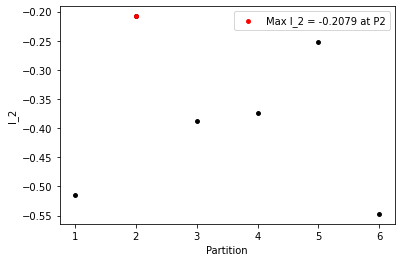


Case 10:

Given (gamma,lambda) = (0.99,0.02), the reconstruction error = 0.0086 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0191  0.0318]
 [ 0.0053  0.0088]
 [-0.      0.    ]
 [ 0.0108  0.018 ]]

Matrix B:
[[ 3.8756  1.8365 -0.      3.0534]
 [ 6.4569  3.0595  0.      5.0874]]

Covariance matrix of Z:
[[0.0027 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 0.8834 -0.1942]
 [-0.1942  0.6764]]

Minimum value of the cost function:
-6.4748

Mutual information of the encoder:
0.29

Mutual information of the decoder:
0.2922

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004 -0.      0.0008]
 [ 0.0004  0.0017 -0.      0.0002]
 [-0.     -0.      0.0016  0.    ]
 [ 0.0008  0.0002  0.      0.0024]]

Reconstruction error:
0.0086

Mutual information between generative variable and latent variable:
0.1592


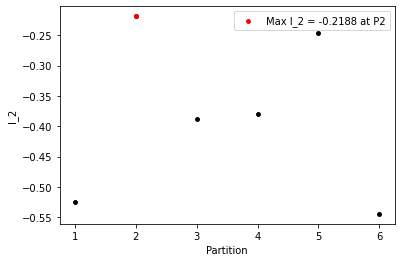


Case 11:

Given (gamma,lambda) = (1.0,-0.02), the reconstruction error = 0.0001 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[-0.0072  0.0393]
 [-0.002   0.0098]
 [ 0.0003  0.0001]
 [-0.0035  0.0197]]

Matrix B:
[[-1.5254 -0.6875  0.1751 -0.8761]
 [ 8.253   3.2207  0.0321  5.1979]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[0.9845 0.0839]
 [0.0839 0.5417]]

Minimum value of the cost function:
-6.5436

Mutual information of the encoder:
0.321

Mutual information of the decoder:
0.321

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004 -0.      0.0008]
 [ 0.0004  0.0017 -0.      0.0002]
 [-0.     -0.      0.0016  0.    ]
 [ 0.0008  0.0002  0.      0.0024]]

Reconstruction error:
0.0001

Mutual information between generative variable and latent variable:
0.1778

Cov

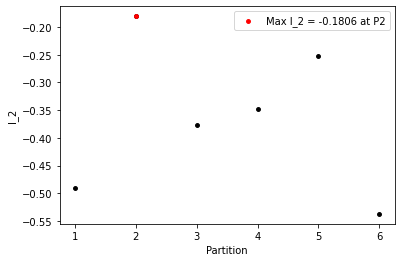


Case 12:

Given (gamma,lambda) = (1.0,-0.01), the reconstruction error = 0.0001 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0108  0.0384]
 [ 0.0037  0.0094]
 [ 0.     -0.    ]
 [ 0.0043  0.0196]]

Matrix B:
[[ 2.3066e+00  1.5080e+00  6.0000e-04  9.1320e-01]
 [ 8.0421e+00  3.0135e+00 -2.0000e-04  5.2450e+00]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 0.9656 -0.1206]
 [-0.1206  0.5602]]

Minimum value of the cost function:
-6.5435

Mutual information of the encoder:
0.3209

Mutual information of the decoder:
0.3209

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004  0.      0.0008]
 [ 0.0004  0.0017  0.      0.0002]
 [ 0.      0.      0.0016 -0.    ]
 [ 0.0008  0.0002 -0.      0.0024]]

Reconstruction error:
0.0001

Mutual information between generative

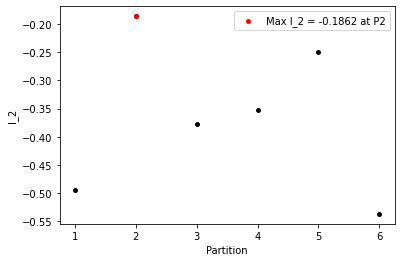


Case 13:

Given (gamma,lambda) = (1.0,0.0), the reconstruction error = 0.0 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0141  0.0374]
 [ 0.0034  0.0094]
 [-0.0003  0.0001]
 [ 0.0072  0.0187]]

Matrix B:
[[ 2.9662  1.0927 -0.1732  1.9174]
 [ 7.869   3.0993  0.0656  4.895 ]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 0.9405 -0.157 ]
 [-0.157   0.5851]]

Minimum value of the cost function:
-6.5434

Mutual information of the encoder:
0.3216

Mutual information of the decoder:
0.3216

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004  0.      0.0008]
 [ 0.0004  0.0017  0.      0.0002]
 [ 0.      0.      0.0016 -0.    ]
 [ 0.0008  0.0002 -0.      0.0024]]

Reconstruction error:
0.0

Mutual information between generative variable and latent variable:
0.1781

Covar

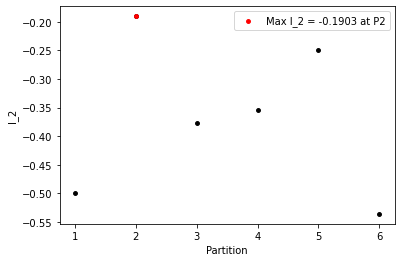


Case 14:

Given (gamma,lambda) = (1.0,0.01), the reconstruction error = 0.0001 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0241  0.032 ]
 [ 0.006   0.008 ]
 [ 0.0003 -0.0002]
 [ 0.012   0.016 ]]

Matrix B:
[[ 5.0631  1.9686  0.205   3.1645]
 [ 6.7255  2.626  -0.1544  4.1883]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 0.8281 -0.2281]
 [-0.2281  0.6971]]

Minimum value of the cost function:
-6.5434

Mutual information of the encoder:
0.3219

Mutual information of the decoder:
0.3219

Value of Sigma_X:
[[ 1. -0.]
 [-0.  1.]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004 -0.      0.0008]
 [ 0.0004  0.0017 -0.      0.0002]
 [-0.     -0.      0.0016  0.    ]
 [ 0.0008  0.0002  0.      0.0024]]

Reconstruction error:
0.0001

Mutual information between generative variable and latent variable:
0.

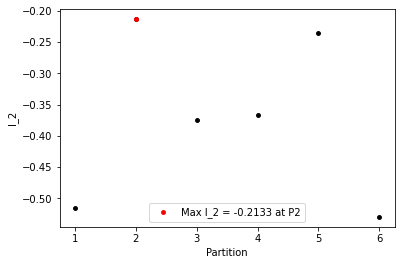


Case 15:

Given (gamma,lambda) = (1.0,0.02), the reconstruction error = 0.0001 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0126  0.038 ]
 [ 0.003   0.0095]
 [-0.0002  0.0001]
 [ 0.0066  0.0188]]

Matrix B:
[[ 2.6219  0.932  -0.1026  1.8181]
 [ 8.0063  3.1463  0.0343  4.9222]]

Covariance matrix of Z:
[[0.0025 0.     0.     0.    ]
 [0.     0.0016 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.002 ]]

Covariance matrix of W:
[[ 0.9521 -0.1428]
 [-0.1428  0.5728]]

Minimum value of the cost function:
-6.5433

Mutual information of the encoder:
0.3222

Mutual information of the decoder:
0.3222

Value of Sigma_X:
[[1. 0.]
 [0. 1.]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004  0.      0.0008]
 [ 0.0004  0.0017  0.      0.0002]
 [ 0.      0.      0.0016 -0.    ]
 [ 0.0008  0.0002 -0.      0.0024]]

Reconstruction error:
0.0001

Mutual information between generative variable and latent variable:
0.1785

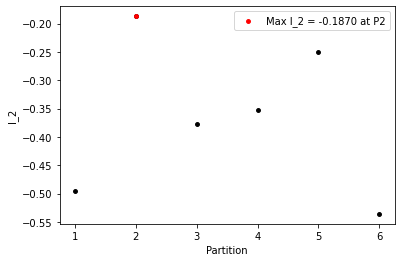


Case 16:

Given (gamma,lambda) = (1.01,-0.02), the reconstruction error = 0.0049 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0451  0.0452]
 [ 0.0026  0.0062]
 [ 0.      0.    ]
 [-0.0246  0.0422]]

Matrix B:
[[ 13.9872  -0.       0.     -14.9708]
 [  8.1566   0.       0.      14.9583]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
132373.6356

Mutual information of the encoder:
46.5503

Mutual information of the decoder:
46.5354

Value of Sigma_X:
[[ 1.005 -0.   ]
 [-0.     1.005]]

Value of Sigma_Y_hat:
[[0.0041 0.0004 0.     0.0008]
 [0.0004 0.0017 0.     0.0002]
 [0.     0.     0.0016 0.    ]
 [0.0008 0.0002 0.     0.0024]]

Reconstruction error:
0.0049

Mutual information between generative variable and latent variable:
0.6396

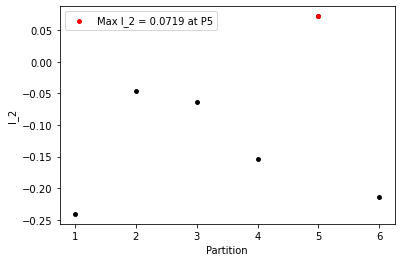


Case 17:

Given (gamma,lambda) = (1.01,-0.01), the reconstruction error = 0.0048 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0483  0.0417]
 [-0.0219  0.0348]
 [-0.     -0.    ]
 [ 0.0075  0.0104]]

Matrix B:
[[ 13.4185 -16.0757   0.      -0.    ]
 [  8.4155  18.618   -0.       0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
-9.0842

Mutual information of the encoder:
46.5336

Mutual information of the decoder:
46.5187

Value of Sigma_X:
[[ 1.005 -0.   ]
 [-0.     1.005]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004 -0.      0.0008]
 [ 0.0004  0.0017 -0.      0.0002]
 [-0.     -0.      0.0016 -0.    ]
 [ 0.0008  0.0002 -0.      0.0024]]

Reconstruction error:
0.0048

Mutual information between generative variable and latent vari

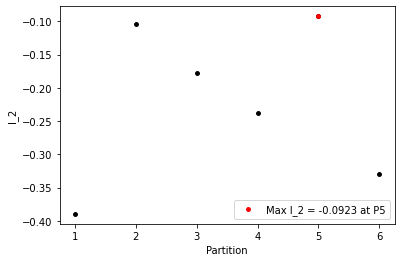


Case 18:

Given (gamma,lambda) = (1.01,0.0), the reconstruction error = 0.0049 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0606 -0.0203]
 [ 0.0051 -0.0044]
 [ 0.     -0.    ]
 [-0.0032 -0.0488]]

Matrix B:
[[ 16.1566  -0.       0.      -6.7322]
 [ -1.0656  -0.       0.     -20.0637]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[0. 0.]
 [0. 0.]]

Minimum value of the cost function:
132373.6373

Mutual information of the encoder:
46.3831

Mutual information of the decoder:
46.3682

Value of Sigma_X:
[[1.005 0.   ]
 [0.    1.005]]

Value of Sigma_Y_hat:
[[0.0041 0.0004 0.     0.0008]
 [0.0004 0.0017 0.     0.0002]
 [0.     0.     0.0016 0.    ]
 [0.0008 0.0002 0.     0.0024]]

Reconstruction error:
0.0049

Mutual information between generative variable and latent variable:
0.6396

Covarian

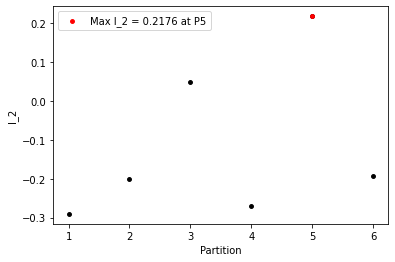


Case 19:

Given (gamma,lambda) = (1.01,0.01), the reconstruction error = 0.0049 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.04    0.0498]
 [ 0.0059  0.0033]
 [ 0.      0.    ]
 [ 0.0447 -0.0199]]

Matrix B:
[[  6.5803   0.       0.      16.5037]
 [ 14.7942  -0.       0.     -13.2477]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
66182.2754

Mutual information of the encoder:
46.5854

Mutual information of the decoder:
46.5704

Value of Sigma_X:
[[ 1.005 -0.   ]
 [-0.     1.005]]

Value of Sigma_Y_hat:
[[0.0041 0.0004 0.     0.0008]
 [0.0004 0.0017 0.     0.0002]
 [0.     0.     0.0016 0.    ]
 [0.0008 0.0002 0.     0.0024]]

Reconstruction error:
0.0049

Mutual information between generative variable and latent variable:
0.6396



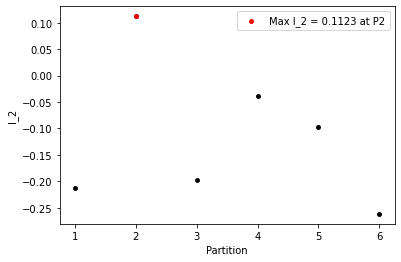


Case 20:

Given (gamma,lambda) = (1.01,0.02), the reconstruction error = 0.0049 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0322  0.0551]
 [ 0.0009  0.0067]
 [ 0.      0.    ]
 [-0.0345  0.0346]]

Matrix B:
[[ 11.468   -0.       0.     -18.2687]
 [ 11.4305   0.       0.      10.6832]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
-9.0892

Mutual information of the encoder:
47.0485

Mutual information of the decoder:
47.0336

Value of Sigma_X:
[[ 1.005 -0.   ]
 [-0.     1.005]]

Value of Sigma_Y_hat:
[[0.0041 0.0004 0.     0.0008]
 [0.0004 0.0017 0.     0.0002]
 [0.     0.     0.0016 0.    ]
 [0.0008 0.0002 0.     0.0024]]

Reconstruction error:
0.0049

Mutual information between generative variable and latent variable:
0.6396

Cov

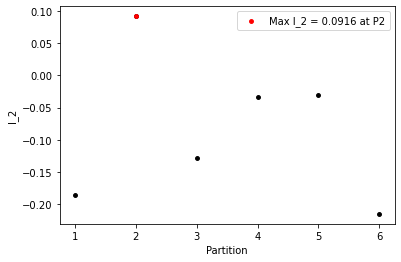


Case 21:

Given (gamma,lambda) = (1.02,-0.02), the reconstruction error = 0.0095 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0426  0.0474]
 [-0.026   0.0317]
 [ 0.      0.    ]
 [ 0.0061  0.0112]]

Matrix B:
[[ 12.2798 -18.341    0.      -0.    ]
 [ 10.0657  16.482    0.       0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
-3.15674710017772e+26

Mutual information of the encoder:
95.475

Mutual information of the decoder:
95.4453

Value of Sigma_X:
[[ 1.0099 -0.    ]
 [-0.      1.0099]]

Value of Sigma_Y_hat:
[[0.0041 0.0004 0.     0.0008]
 [0.0004 0.0017 0.     0.0002]
 [0.     0.     0.0016 0.    ]
 [0.0008 0.0002 0.     0.0024]]

Reconstruction error:
0.0095

Mutual information between generative variable and latent var

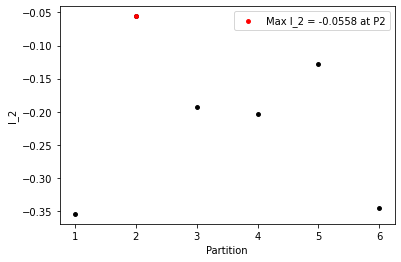


Case 22:

Given (gamma,lambda) = (1.02,-0.01), the reconstruction error = 0.0095 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0286  0.057 ]
 [-0.0335  0.0237]
 [ 0.      0.    ]
 [ 0.0029  0.0124]]

Matrix B:
[[  9.1857 -22.0425   0.      -0.    ]
 [ 12.9513  11.0532   0.       0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
6.31349420035544e+26

Mutual information of the encoder:
94.7711

Mutual information of the decoder:
94.7414

Value of Sigma_X:
[[ 1.0099 -0.    ]
 [-0.      1.0099]]

Value of Sigma_Y_hat:
[[0.0041 0.0004 0.     0.0008]
 [0.0004 0.0017 0.     0.0002]
 [0.     0.     0.0016 0.    ]
 [0.0008 0.0002 0.     0.0024]]

Reconstruction error:
0.0095

Mutual information between generative variable and latent var

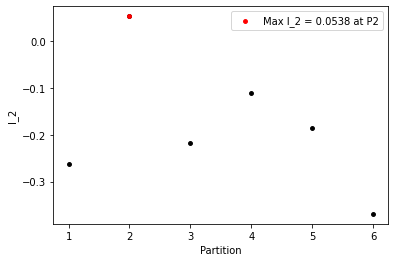


Case 23:

Given (gamma,lambda) = (1.02,0.0), the reconstruction error = 0.0095 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0183  0.061 ]
 [-0.0371  0.0176]
 [ 0.     -0.    ]
 [ 0.0007  0.0128]]

Matrix B:
[[  6.8049 -23.6232   0.      -0.    ]
 [ 14.3459   7.0705  -0.       0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
-1.57837355008886e+26

Mutual information of the encoder:
95.5315

Mutual information of the decoder:
95.5018

Value of Sigma_X:
[[ 1.0099 -0.    ]
 [-0.      1.0099]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004 -0.      0.0008]
 [ 0.0004  0.0017 -0.      0.0002]
 [-0.     -0.      0.0016 -0.    ]
 [ 0.0008  0.0002 -0.      0.0024]]

Reconstruction error:
0.0095

Mutual information between generative variable

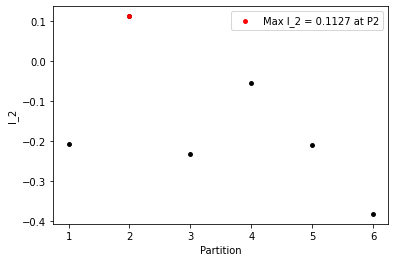


Case 24:

Given (gamma,lambda) = (1.02,0.01), the reconstruction error = 0.0098 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0332  0.0544]
 [ 0.0054  0.004 ]
 [-0.     -0.    ]
 [ 0.0467 -0.014 ]]

Matrix B:
[[  4.6463   0.       0.      18.1065]
 [ 15.5523  -0.      -0.     -11.0563]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.0017 0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.    ]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
3.15674710017772e+26

Mutual information of the encoder:
96.0466

Mutual information of the decoder:
96.0169

Value of Sigma_X:
[[ 1.0099 -0.    ]
 [-0.      1.0099]]

Value of Sigma_Y_hat:
[[ 0.0041  0.0004 -0.      0.0008]
 [ 0.0004  0.0017 -0.      0.0002]
 [-0.     -0.      0.0016 -0.    ]
 [ 0.0008  0.0002 -0.      0.0024]]

Reconstruction error:
0.0098

Mutual information between generative variable

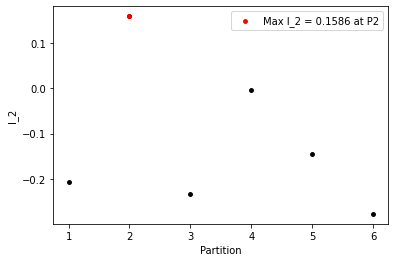


Case 25:

Given (gamma,lambda) = (1.02,0.02), the reconstruction error = 0.0095 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

Optimal solution:
Matrix A:
[[ 0.0401  0.0495]
 [-0.0276  0.0303]
 [ 0.      0.    ]
 [ 0.0055  0.0115]]

Matrix B:
[[ 11.7381 -19.1757   0.      -0.    ]
 [ 10.6926  15.5028  -0.       0.    ]]

Covariance matrix of Z:
[[0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.0016 0.    ]
 [0.     0.     0.     0.0022]]

Covariance matrix of W:
[[ 0. -0.]
 [-0.  0.]]

Minimum value of the cost function:
-10.5901

Mutual information of the encoder:
94.8074

Mutual information of the decoder:
94.7777

Value of Sigma_X:
[[ 1.0099 -0.    ]
 [-0.      1.0099]]

Value of Sigma_Y_hat:
[[0.0041 0.0004 0.     0.0008]
 [0.0004 0.0017 0.     0.0002]
 [0.     0.     0.0016 0.    ]
 [0.0008 0.0002 0.     0.0024]]

Reconstruction error:
0.0095

Mutual information between generative variable and latent variable:
0.4892

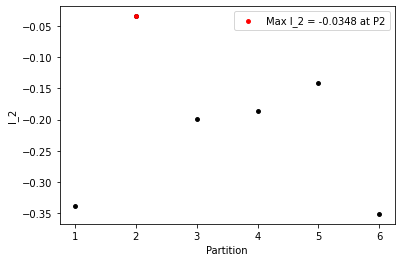

In [11]:
for case in range(num_cases):
    # Compute Sigma_Y given Sigma_V
    Sigma_V = generate_Sigma_V(case)
    
    Sigma_Y = eigenvectors @ Sigma_V @ eigenvectors.T + Sigma_Z_tilde
    print(colored('\nCovariance matrix of input data Y:', 'blue', attrs=['bold']))
    print(np.round(Sigma_Y, 4))
    is_positive_definite(Sigma_Y)
    
    # Constants
    MAX_SOLS = 5
    is_array = 1
    flag = 0
    case_num = 1

    # Initiate arrays
    min_recon_err_arr = []
    min_en_mi_arr = []
    min_de_mi_arr = []
    all_recon_mi_arr = []
    satisfied_recon_mi_arr = []
    satisfied_gamma_lambda_arr = []
    
    # Iteration step
    for i in range(0, len(gamma_arr)):
        gamma = gamma_arr[i]
        for j in range(0, len(lambda_arr)):
            lamda = lambda_arr[j]
        
            min_recon_err, min_en_mi, min_de_mi, min_opt_sol = print_comprehensive_results(gamma, lamda, flag, m, n, is_array)
        
            first_iter = 1
            for num_sols in range(0, MAX_SOLS):
                current_recon_err, current_en_mi, current_de_mi, current_opt_sol = print_comprehensive_results(gamma, lamda, flag, m, n, is_array)
    
                # Check for unique optimal solutions for each (gamma, lambda) pair
                if first_iter == 1:
                    if is_close_to_zero(current_opt_sol[:2*n*m+n*n+m*m] - min_opt_sol[:2*n*m+n*n+m*m], 1e-6):
                        is_unique = 1
                        unique_opt_sol = current_opt_sol[:2*n*m+n*n+m*m]
                    else:
                        is_unique = 0
                    first_iter = 0
                else:
                    if is_unique == 1:
                        if is_close_to_zero(current_opt_sol[:2*n*m+n*n+m*m] - unique_opt_sol, 1e-6):
                            unique_opt_sol = current_opt_sol[:2*n*m+n*n+m*m]
                        else:
                            is_unique = 0
    
                # Return the solution with smallest reconstruction error
                if current_recon_err < min_recon_err:
                    min_recon_err = current_recon_err
                    min_en_mi = current_en_mi
                    min_de_mi = current_de_mi
                    min_opt_sol = current_opt_sol
                
            min_recon_err_arr = np.concatenate((min_recon_err_arr, [min_recon_err]))
            min_en_mi_arr = np.concatenate((min_en_mi_arr, [min_en_mi]))
            min_de_mi_arr = np.concatenate((min_de_mi_arr, [min_de_mi]))
            all_recon_mi_arr = np.concatenate((all_recon_mi_arr, [min_recon_err, min_en_mi, min_de_mi]))
        
            print(colored('\nCase {}:'.format(case_num), 'blue', attrs=['bold']))
            case_num += 1
        
            if min_recon_err > MAX_RECON_ERR:
                print('\nGiven (gamma,lambda) = ({},{}), the reconstruction error = {} that EXCEEDS the tolerance error = {}.\n'.format(gamma, lamda, min_recon_err, MAX_RECON_ERR))
            else:
                print('\nGiven (gamma,lambda) = ({},{}), the reconstruction error = {} that SATISFIES the tolerance error = {}.\n'.format(gamma, lamda, min_recon_err, MAX_RECON_ERR))
            
                satisfied_gamma_lambda_arr = np.concatenate((satisfied_gamma_lambda_arr, [gamma, lamda]))
                satisfied_recon_mi_arr = np.concatenate((satisfied_recon_mi_arr, [min_recon_err, min_en_mi, min_de_mi]))
        
            if is_unique == 1:
                print(colored('The optimal solution is unique!\n', 'blue', attrs=['bold']))
            else:
                print(colored('The optimal solution is NOT unique!\n', 'red', attrs=['bold']))
        
            print_optimal_solution(min_opt_sol, m)
        
            # Compute mutual information I(V;X) and I_2
            B_opt = min_opt_sol[n*m:2*n*m].reshape((m, n))
            Sigma_W_opt = min_opt_sol[2*n*m+n*n:2*n*m+n*n+m*m].reshape((m, m))
        
            mutual_info_VX = mi_VX(B_opt, Sigma_W_opt)
            print('\nMutual information between generative variable and latent variable:')
            print(round(mutual_info_VX, 4))
        
            cov_XV = covariance_matrix_XV(B_opt)
            I2_arr = max_I2(cov_XV)
            plot_I2_vs_partition(I2_arr)